## Fixed and Random Effects Models: A Simulated Study


In this notebook we reproduce the fantastic material from the video [Statistical Rethinking 2026 Lecture B04 - Group-level confounding and intro to social networks](https://www.youtube.com/watch?v=XNNcN8sU8us) by Richard McElreath. This is a great video to understand the difference between fixed and random effects models. It is a must watch! Here we use PyMC to fit the models and compare the results.

## Prepare Notebook

In [1]:
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from pymc import do

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = 42
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generate Data

Here we define the generative model in PyMC.

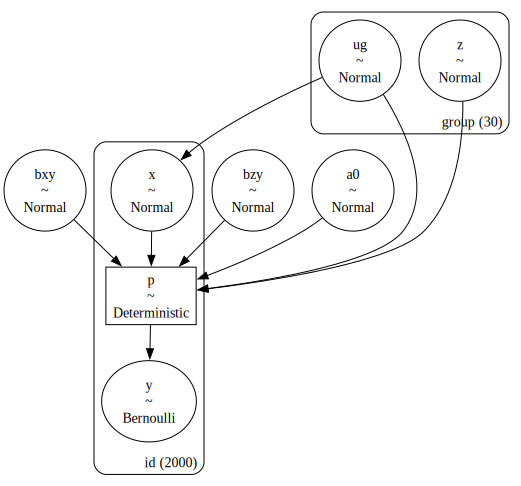

In [3]:
n_groups: int = 30
n_id: int = 2_000
g = rng.choice(n_groups, size=(n_id,), replace=True)

coords: dict[str, Any] = {
    "group": np.arange(n_groups),
    "id": np.arange(n_id),
}

with pm.Model(coords=coords) as generative_model:
    a0 = pm.Normal("a0", mu=0, sigma=1)
    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)
    ug = pm.Normal("ug", mu=0, sigma=1.5, dims="group")
    x = pm.Normal("x", mu=ug[g], sigma=1, dims="id")
    z = pm.Normal("z", mu=0, sigma=1, dims="group")
    p = pm.Deterministic(
        "p", pm.math.invlogit(a0 + bxy * x + ug[g] + bzy * z[g]), dims="id"
    )
    pm.Bernoulli("y", p, dims="id")


pm.model_to_graphviz(generative_model)

We can now set specific values for the parameters and generate a sample that we will use as *observed* data.

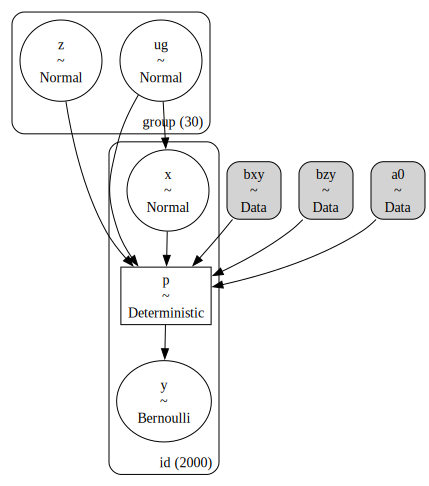

In [4]:
true_params = {"a0": -2, "bzy": 1.0, "bxy": 0.0}

generative_model_do = do(generative_model, true_params)

pm.model_to_graphviz(generative_model_do)

In [5]:
with generative_model_do:
    idata_obs = pm.sample_prior_predictive(draws=1, random_seed=rng)

Sampling: [ug, x, y, z]


In [6]:
ug_obs = idata_obs["prior"]["ug"].sel(chain=0, draw=0).to_numpy()
z_obs = idata_obs["prior"]["z"].sel(chain=0, draw=0).to_numpy()
x_obs = idata_obs["prior"]["x"].sel(chain=0, draw=0).to_numpy()
y_obs = idata_obs["prior"]["y"].sel(chain=0, draw=0).to_numpy()

assert ug_obs.shape == (n_groups,)
assert z_obs.shape == (n_groups,)
assert x_obs.shape == (n_id,)
assert y_obs.shape == (n_id,)

data_df = pd.DataFrame(
    {"group": g, "x": x_obs, "y": y_obs, "z": z_obs[g], "ug": ug_obs[g]}
)

data_df.head()

,group,x,y,z,ug
0,2,-1.636772,0,-0.784611,-0.262631
1,23,-0.630586,0,0.432475,-0.856320
2,19,0.632257,1,-0.802185,-0.376058
3,13,-4.794478,0,0.472600,-3.984009
4,12,1.006184,0,0.196072,0.005123


## Exploratory Data Analysis

Let's look into the data and reproduce the plots from the video. First, we look at the group counts.

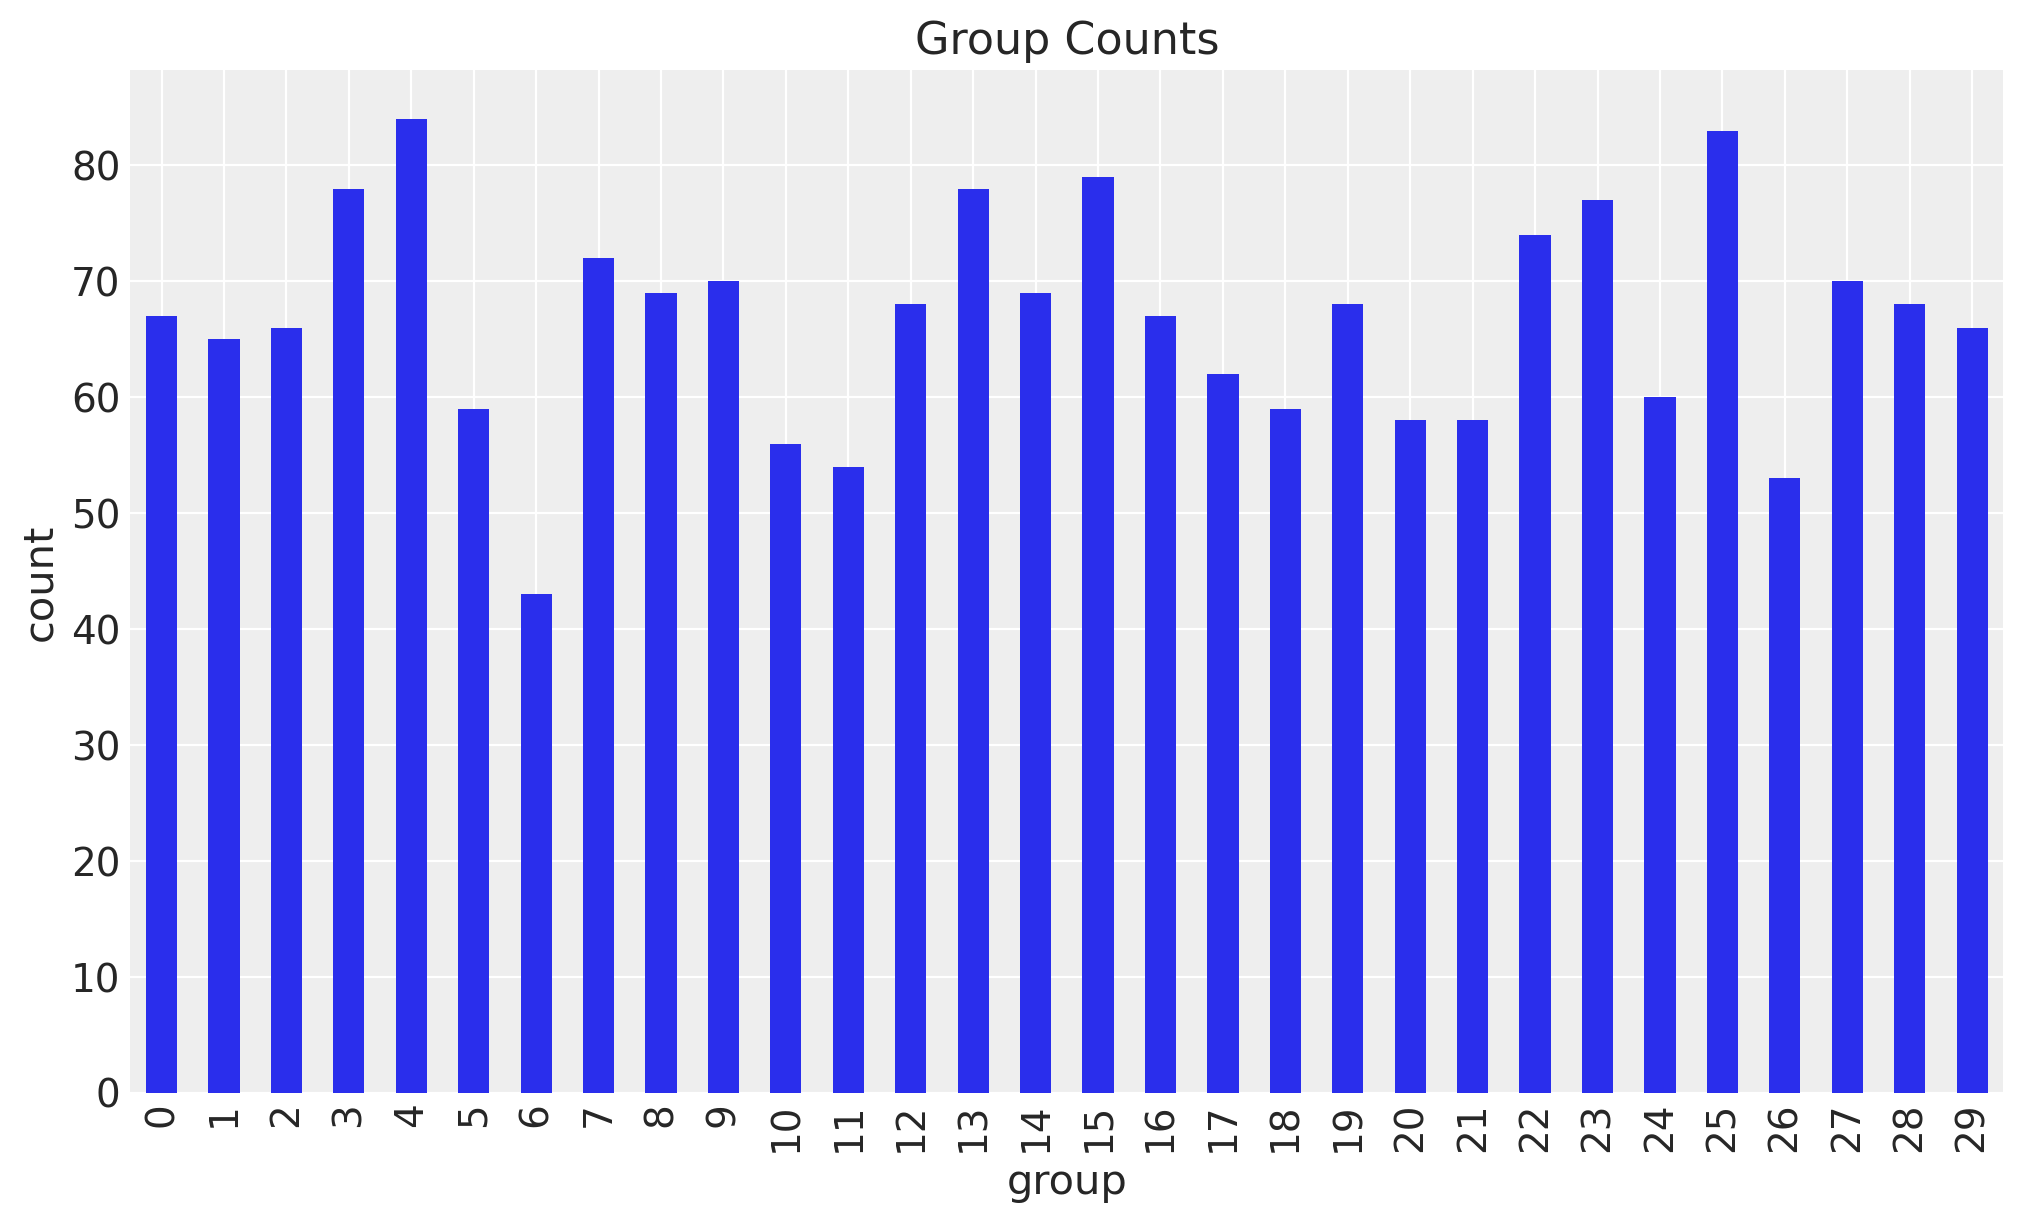

In [7]:
fig, ax = plt.subplots()

data_df.value_counts("group").sort_index().plot.bar(ax=ax)
ax.set(xlabel="group", ylabel="count", title="Group Counts");

We see that each group has a different number of observations.

Next we plot the relationship between the group and the variable of interest $x$.


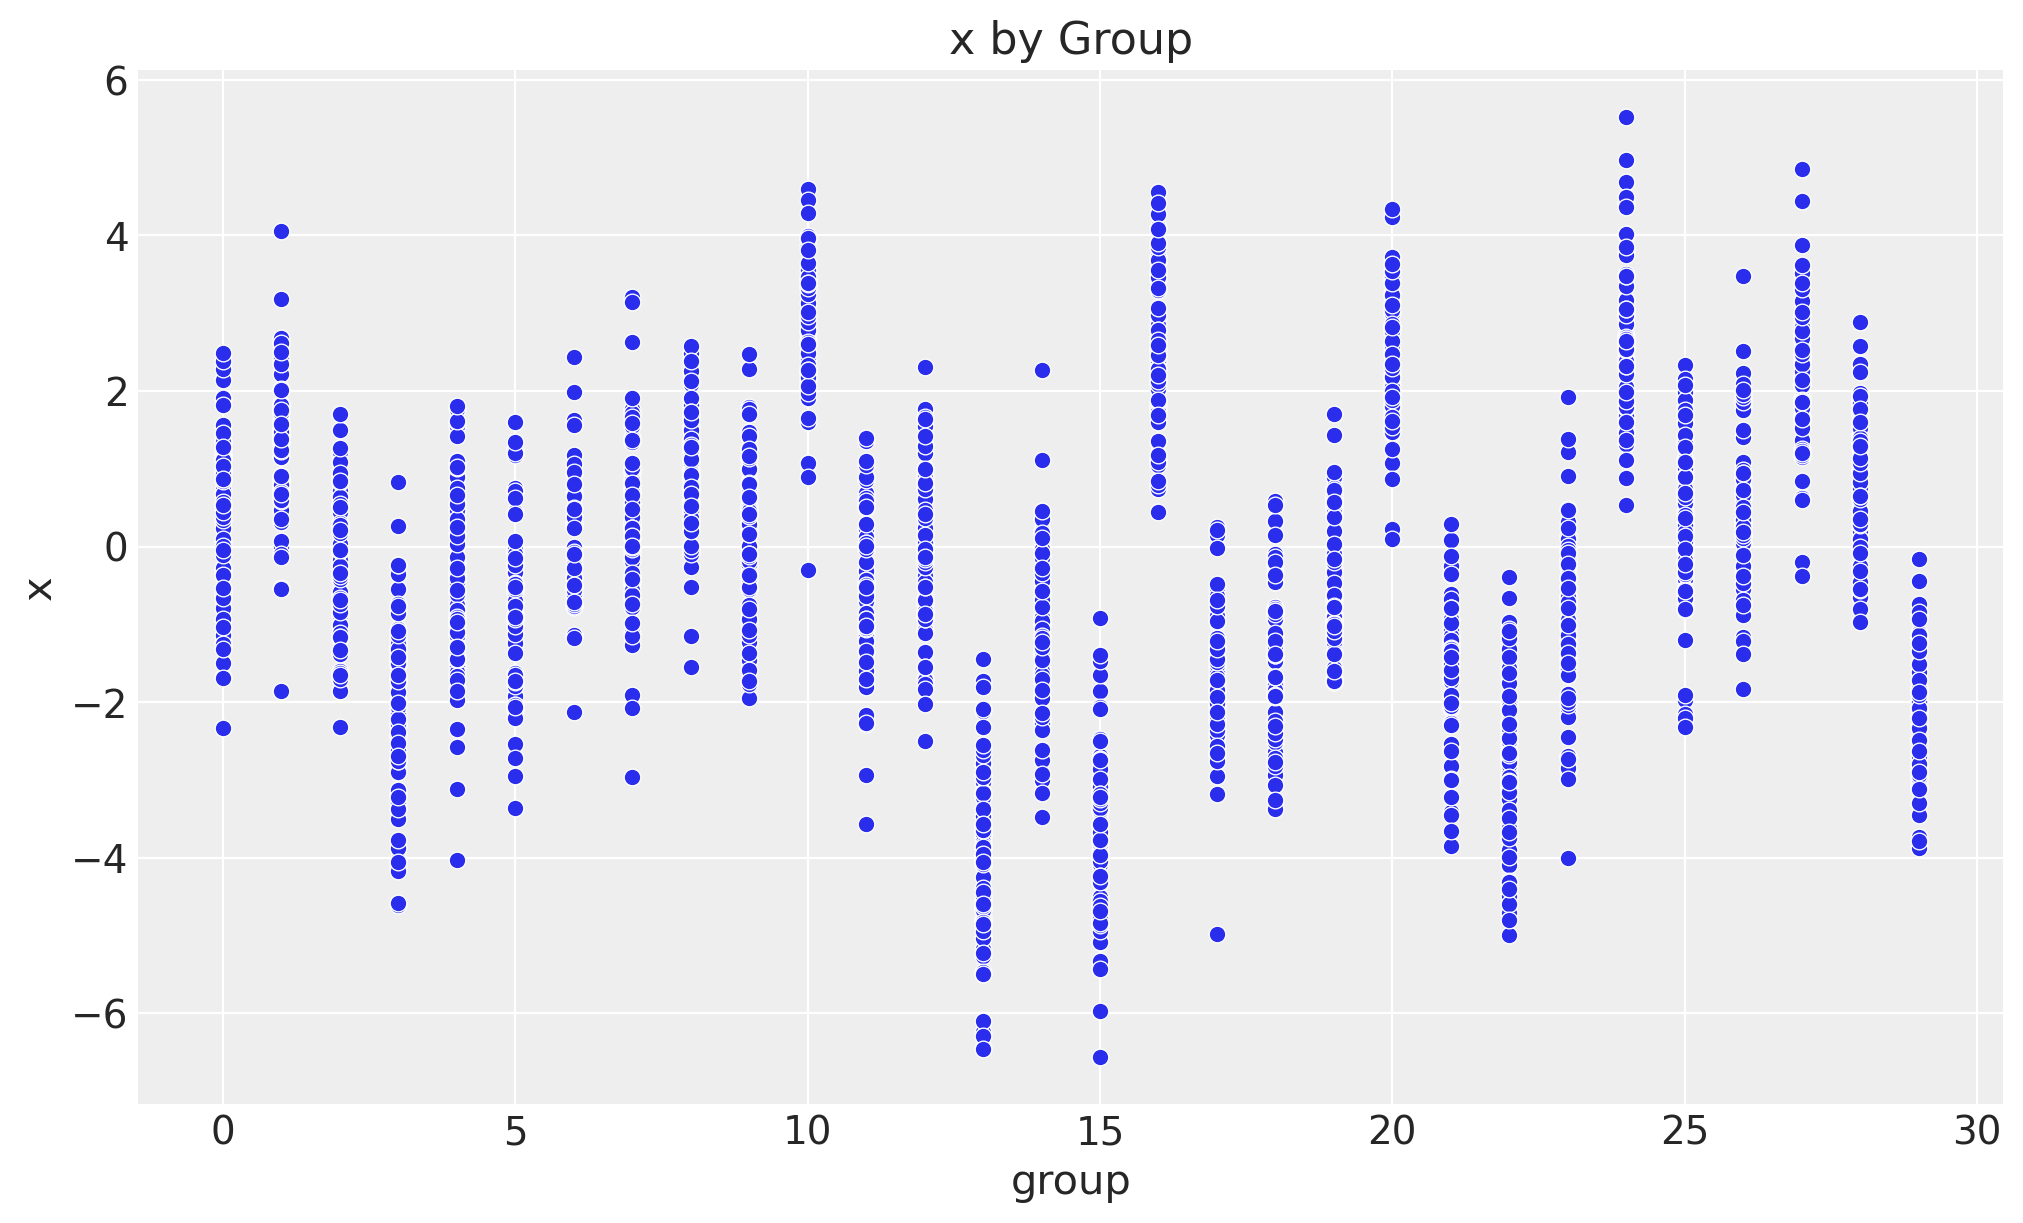

In [8]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="group", y="x", ax=ax)
ax.set(xlabel="group", ylabel="x", title="x by Group");

We clearly see that the mean of $x$ is different for each group.

Now we plot the relationship between $x$ and $y$.

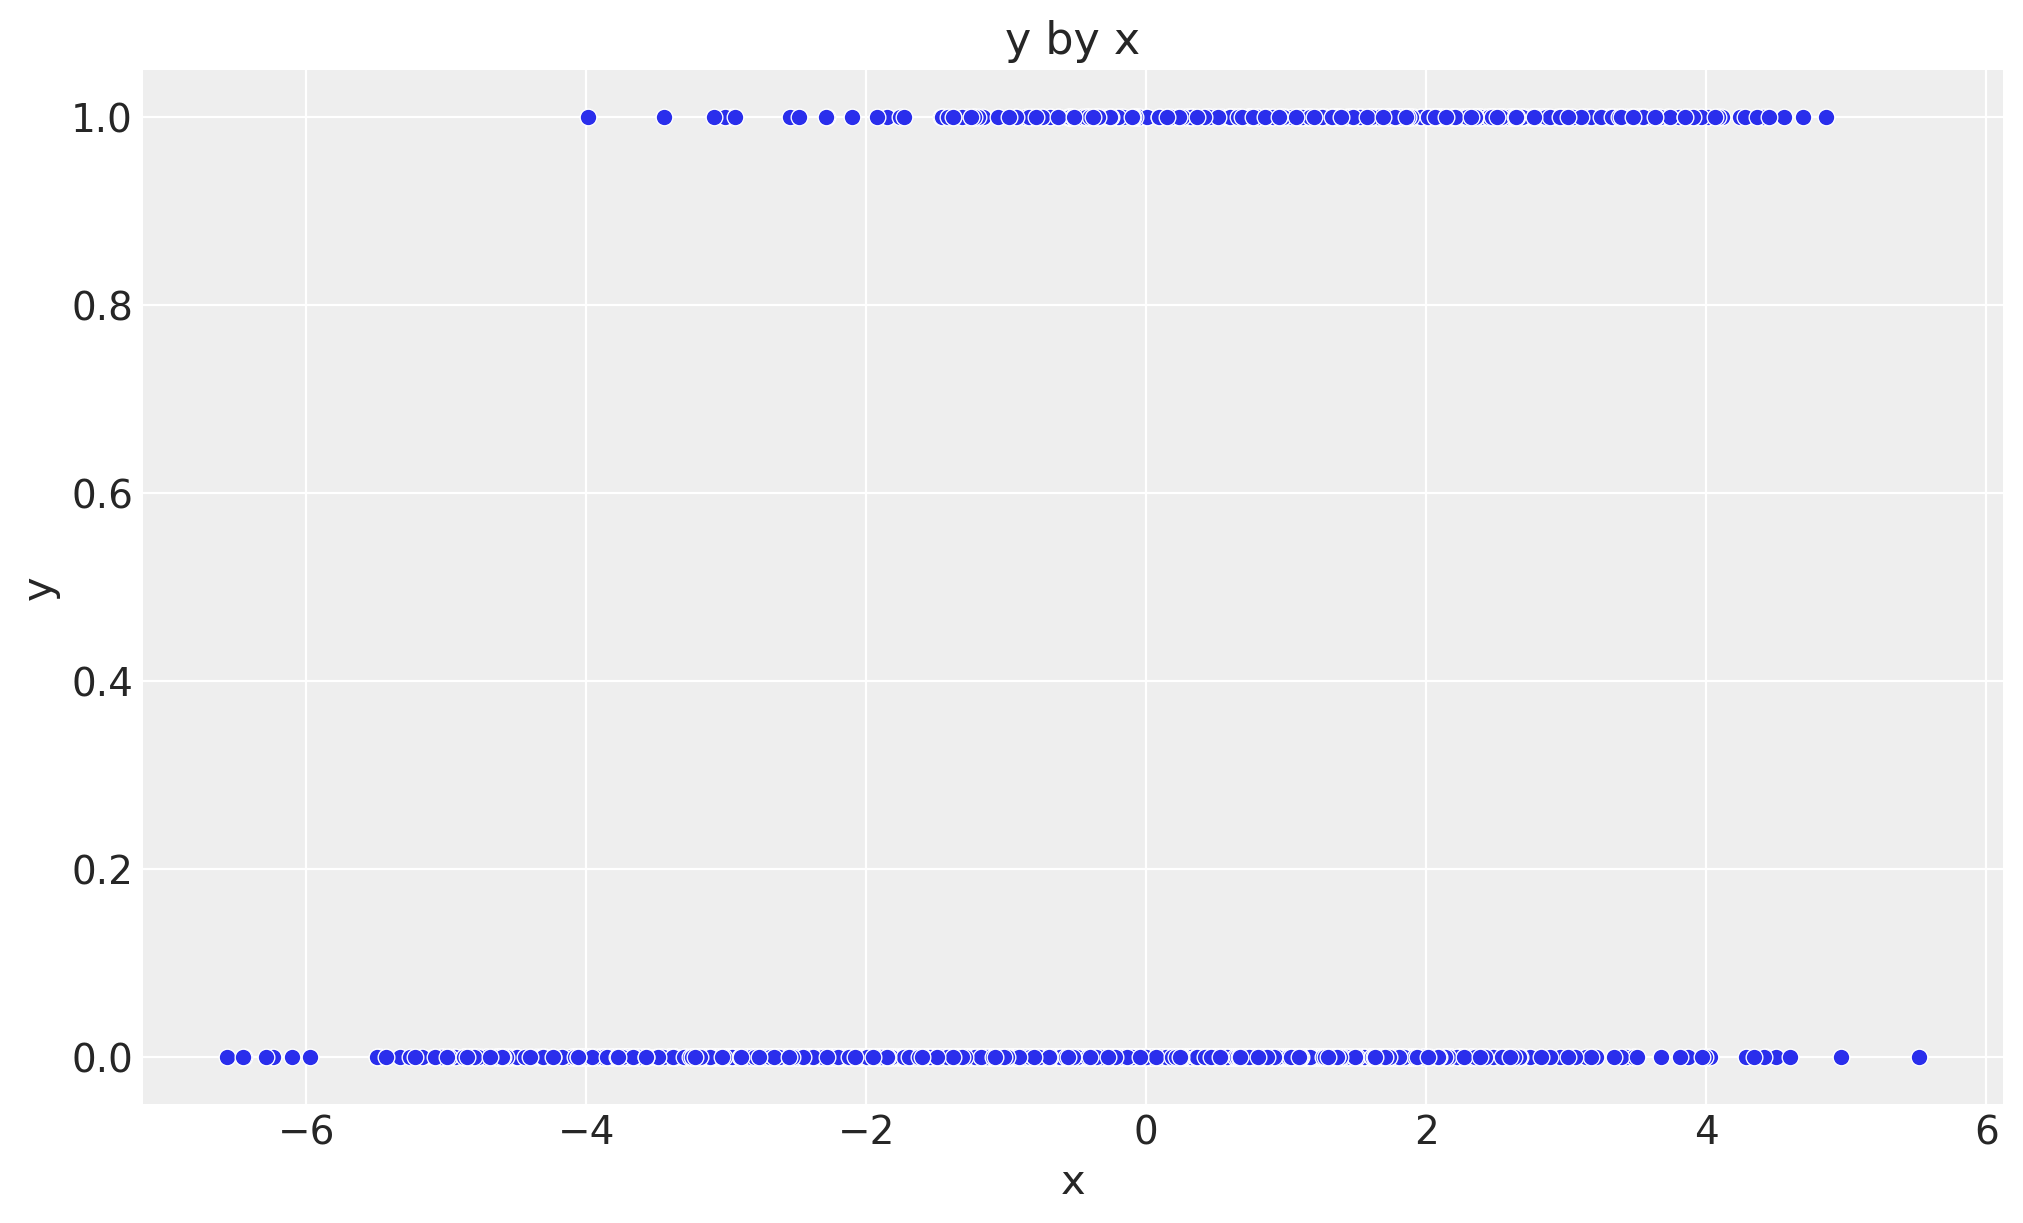

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="x", y="y", ax=ax)
ax.set(xlabel="x", ylabel="y", title="y by x");

It seems that there is a relationship between $x$ and $y$ (the higher $x$ the higher $y$). However, as the true value of $b_{xy}$ is $0$, we know this is just due to the group-level confounding.

Now we are ready to fit all the models from the video.

## Naive Model

First we fit the naive model where we simply ignore the group-level confounding.

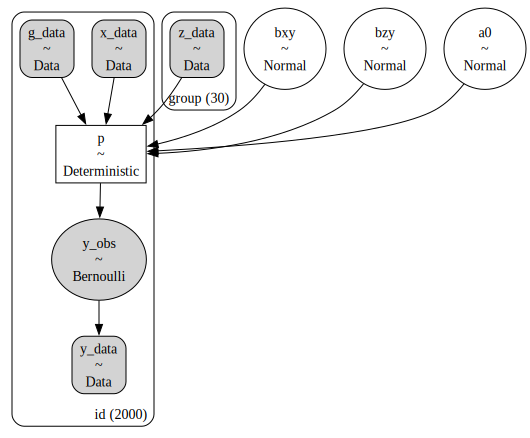

In [10]:
with pm.Model(coords=coords) as naive_model:
    x_data = pm.Data("x_data", x_obs, dims="id")
    y_data = pm.Data("y_data", y_obs, dims="id")
    g_data = pm.Data("g_data", g, dims="id")
    z_data = pm.Data("z_data", z_obs, dims="group")

    a0 = pm.Normal("a0", mu=0, sigma=1)
    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)

    p = pm.Deterministic(
        "p", pm.math.invlogit(a0 + bxy * x_data + bzy * z_data[g_data]), dims="id"
    )
    pm.Bernoulli("y_obs", p, dims="id", observed=y_data)

pm.model_to_graphviz(naive_model)

In [11]:
with naive_model:
    idata_naive = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        cores=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

    pm.compute_log_likelihood(idata_naive)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.06,3
,2000,0,1.08,3
,2000,0,0.93,7
,2000,0,1.08,1


Output()

Let's look at the posterior distributions of the parameters.

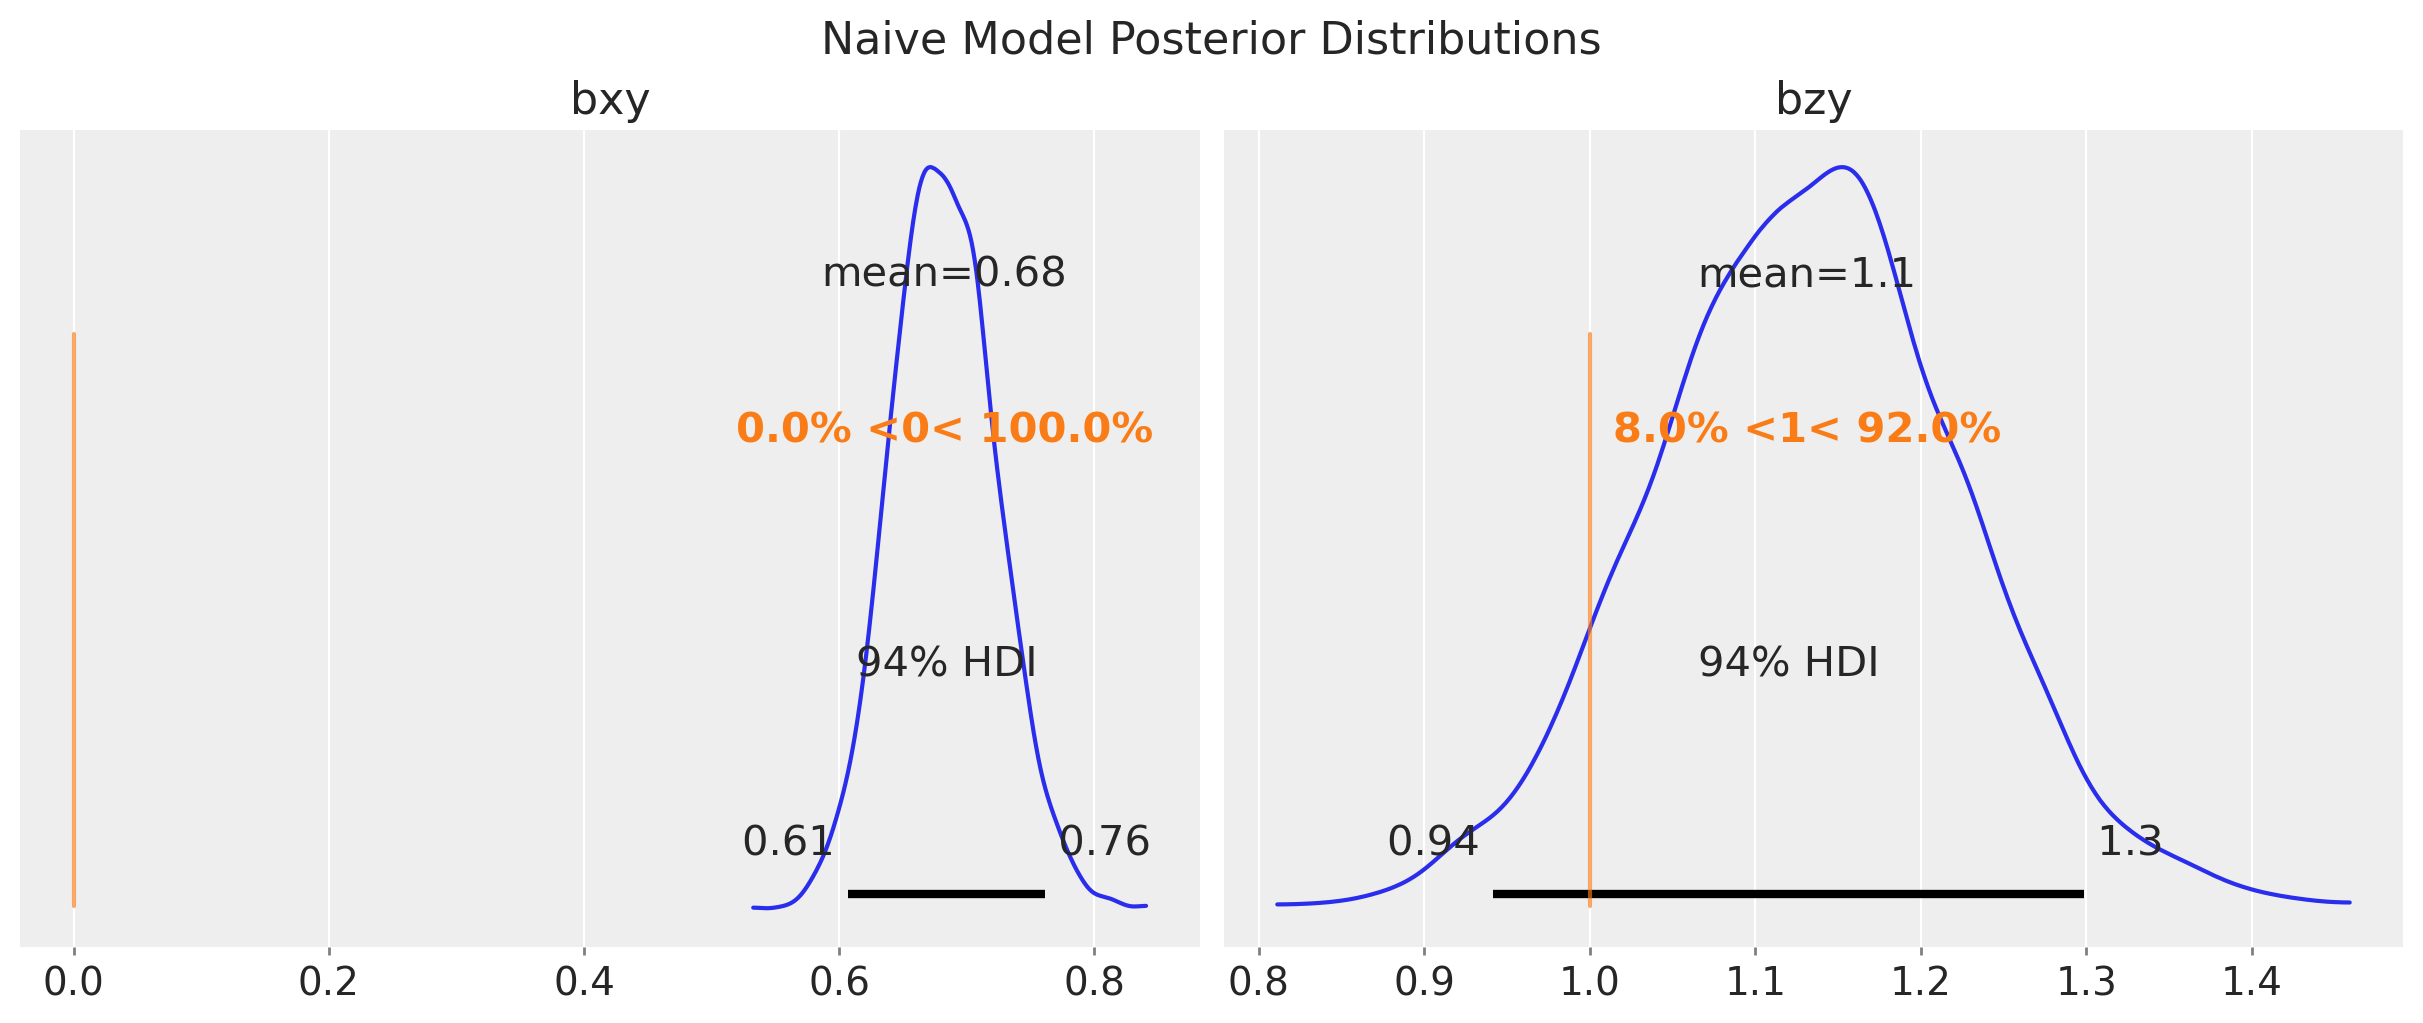

In [12]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Naive Model Posterior Distributions", fontsize=16);

As expected, the posterior distribution of $b_{xy}$ does not include the true value of $0$. The other parameter, $b_{zy}$, is estimated with a high uncertainty.

## Fixed Effects Model

Now we fit the fixed effects model where we control for the group-level confounding by including the group-level intercepts as parameters (no hierarchical structure).

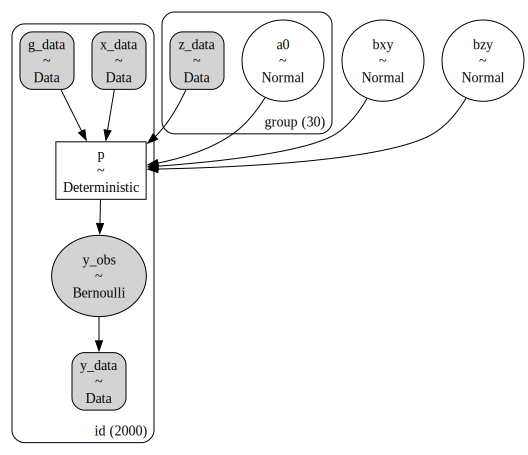

In [13]:
with pm.Model(coords=coords) as fixed_effects_model:
    x_data = pm.Data("x_data", x_obs, dims="id")
    y_data = pm.Data("y_data", y_obs, dims="id")
    g_data = pm.Data("g_data", g, dims="id")
    z_data = pm.Data("z_data", z_obs, dims="group")

    a0 = pm.Normal("a0", mu=0, sigma=10, dims="group")
    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(a0[g_data] + bxy * x_data + bzy * z_data[g_data]),
        dims="id",
    )
    pm.Bernoulli("y_obs", p, dims="id", observed=y_data)

pm.model_to_graphviz(fixed_effects_model)

In [14]:
with fixed_effects_model:
    idata_fixed_effects = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        cores=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

    pm.compute_log_likelihood(idata_fixed_effects)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.32,15
,2000,0,0.33,19
,2000,4,0.35,39
,2000,1,0.31,15


Output()

Let's look at the posterior distributions of the parameters of the fixed effects model.

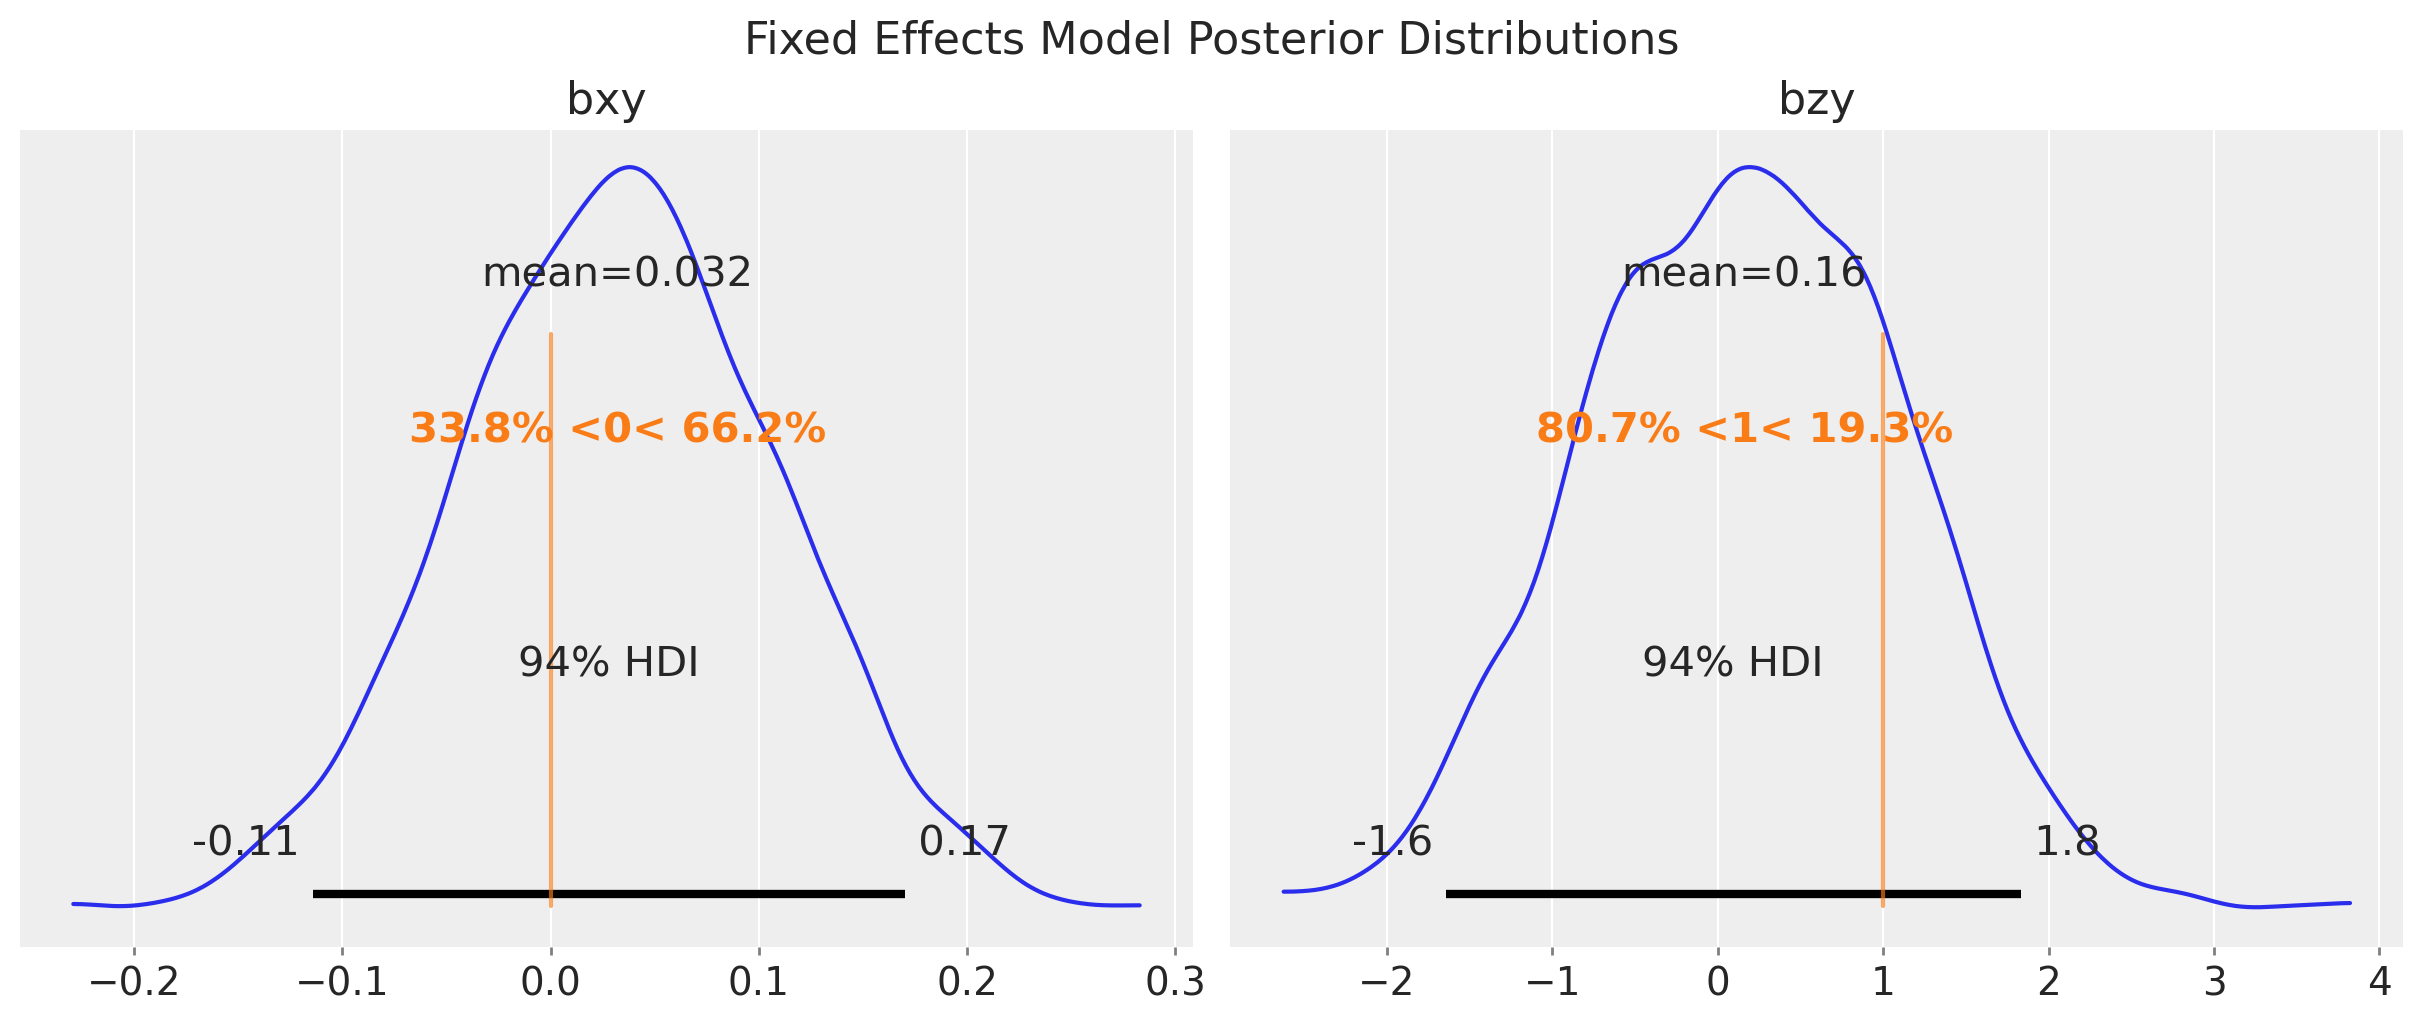

In [15]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Fixed Effects Model Posterior Distributions", fontsize=16);

This model is able to estimate the true value of $b_{xy}$ and $b_{zy}$. We can compare the naive and fixed effects models parameter estimates: 

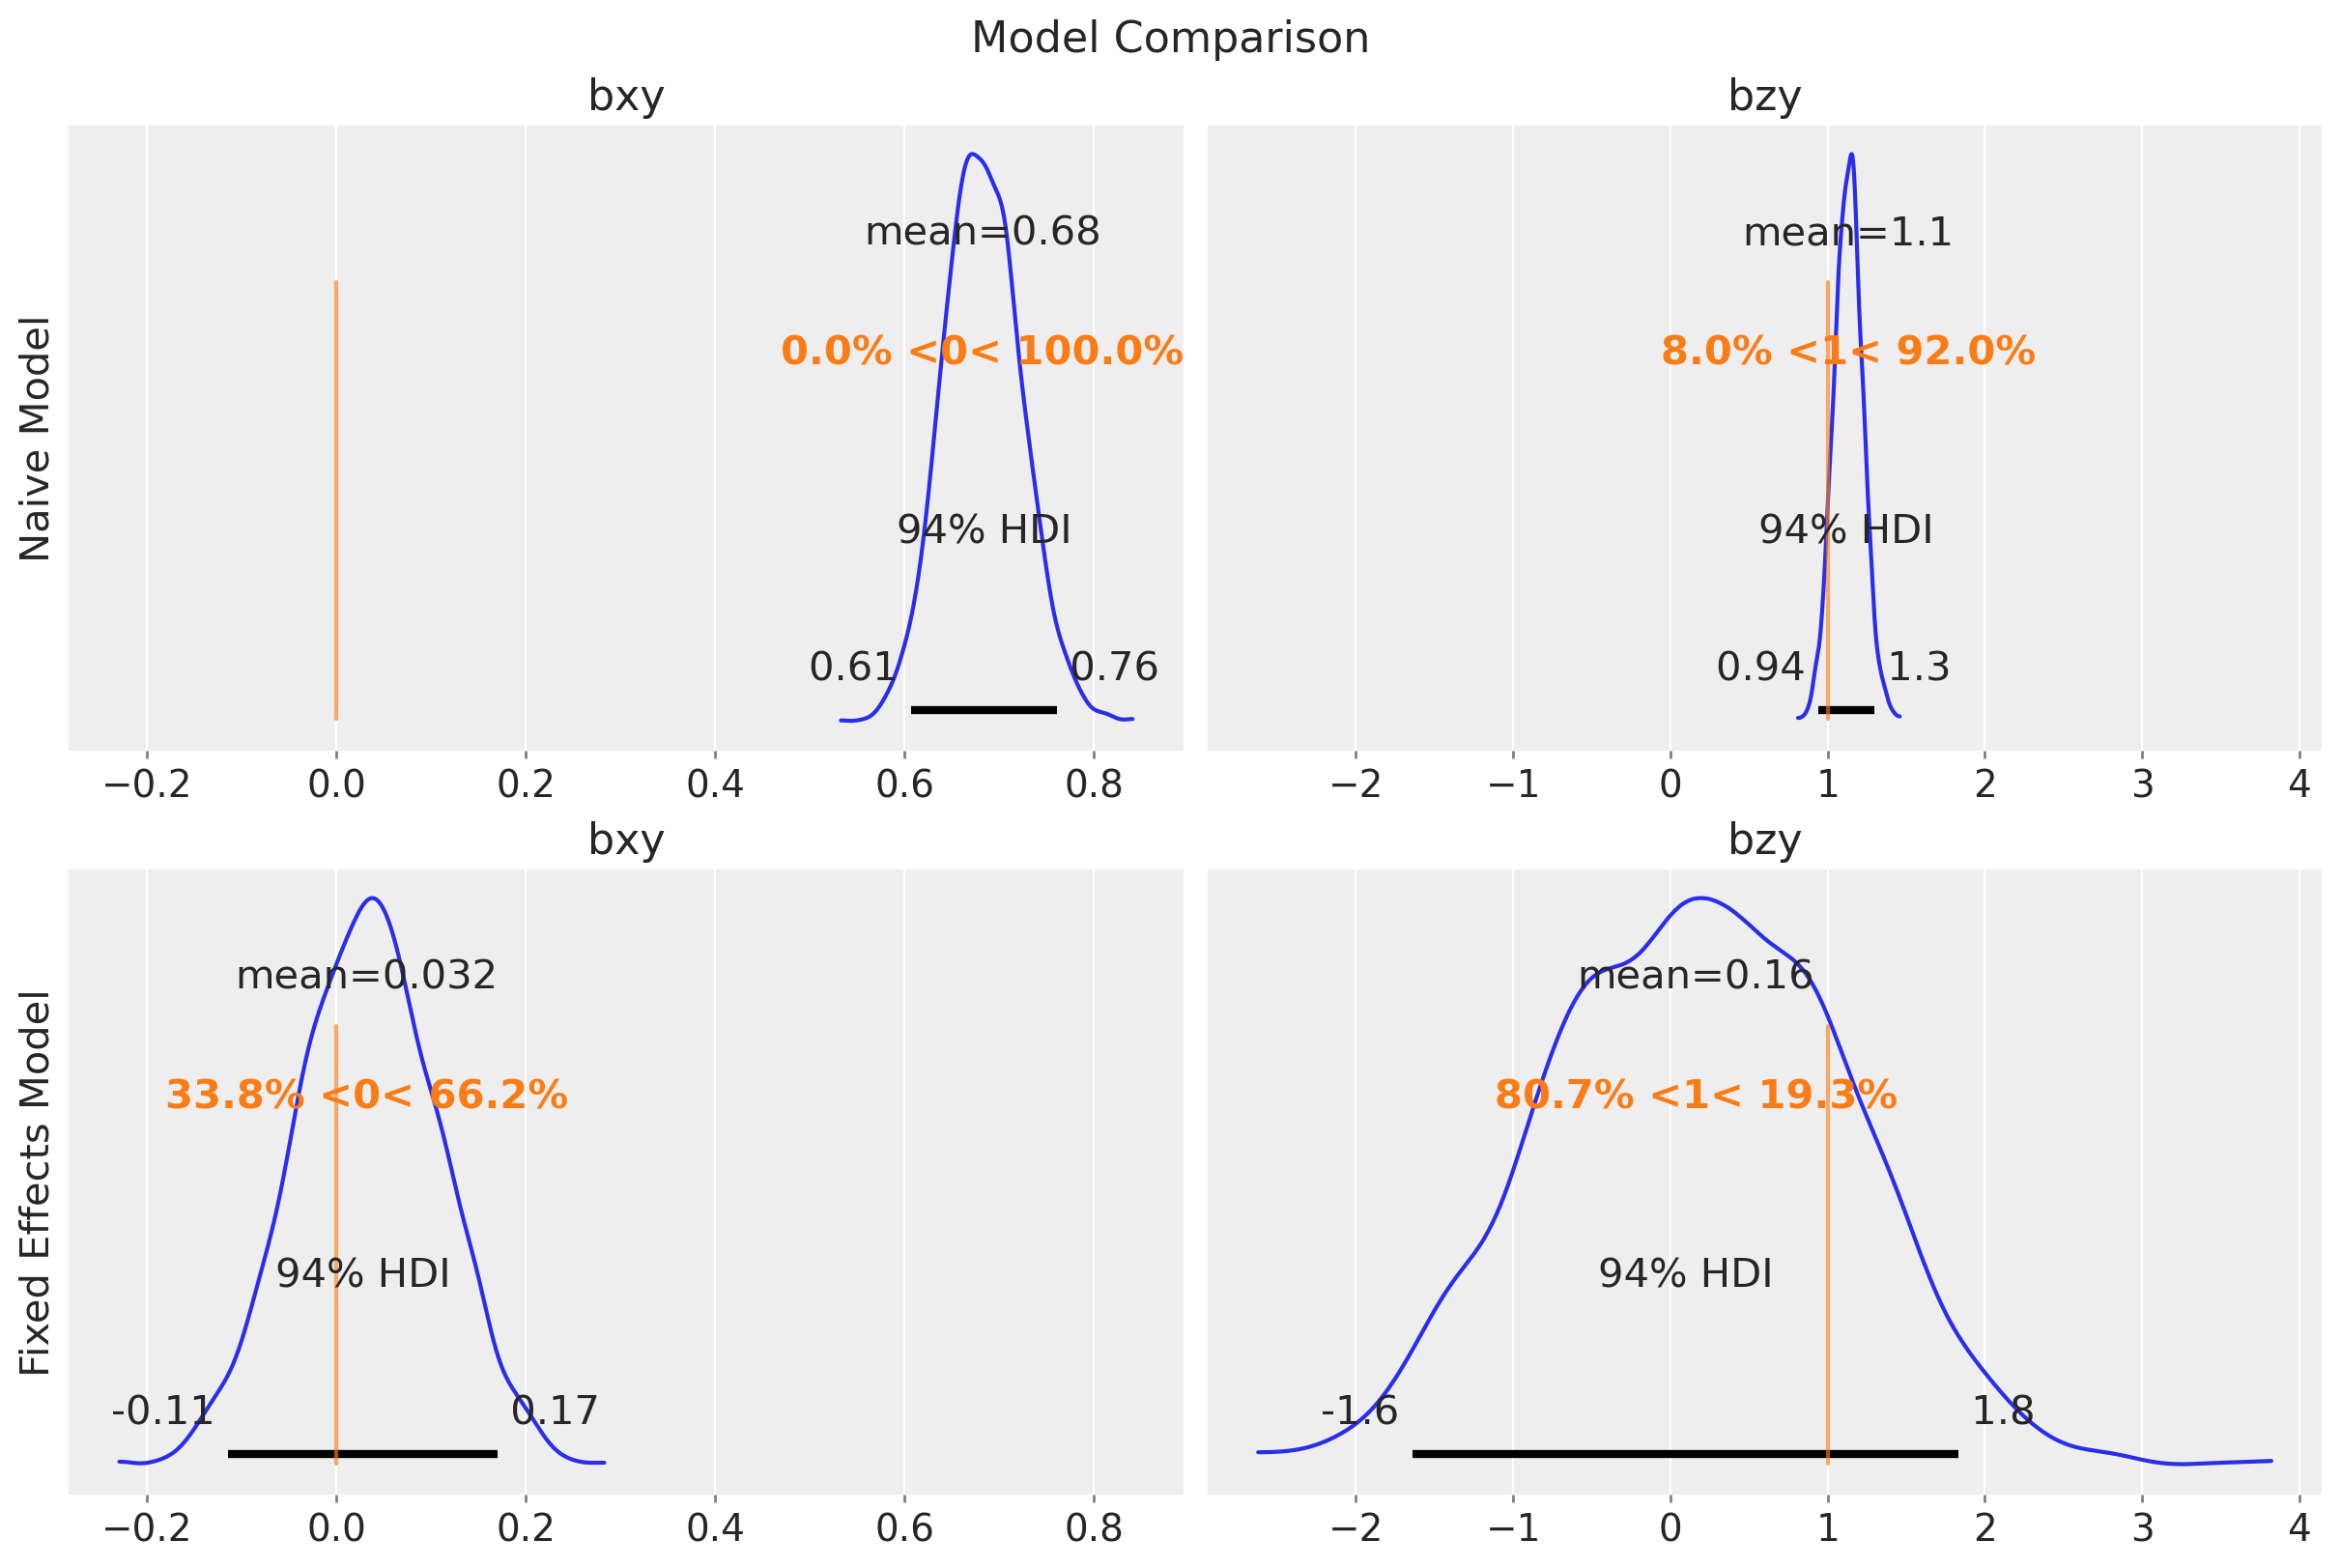

In [16]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12, 8),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

ax[0, 0].set(ylabel="Naive Model")
ax[1, 0].set(ylabel="Fixed Effects Model")

fig.suptitle("Model Comparison", fontsize=16);

Observe that the uncertainty of $b_{zy}$ is higher in the fixed effects model. The reason is because the intercepts and the group-level $z$ terms are not identifiable (there are many ways to sum up two numbers to get the same group-level intercept).

## Multilevel Model

Now we fit a multilevel model where we control for the group-level confounding by including the group-level intercepts as parameters and a hierarchical structure. We use a non-centered parameterization to improve the sampling efficiency.

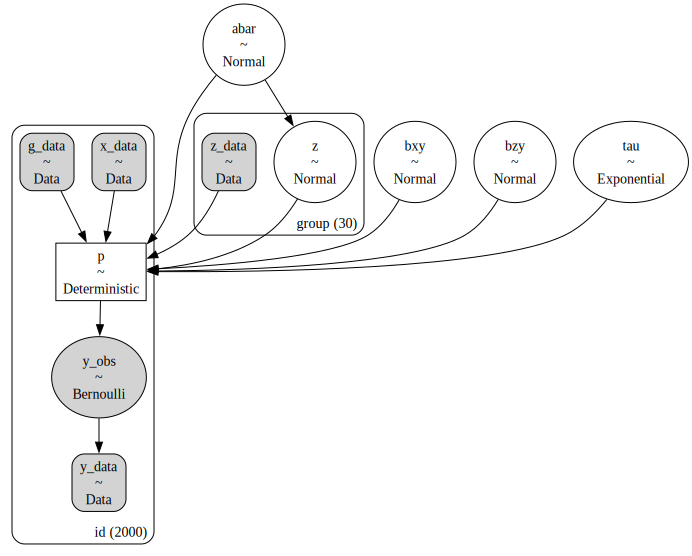

In [17]:
with pm.Model(coords=coords) as multilevel_model:
    x_data = pm.Data("x_data", x_obs, dims="id")
    y_data = pm.Data("y_data", y_obs, dims="id")
    g_data = pm.Data("g_data", g, dims="id")
    z_data = pm.Data("z_data", z_obs, dims="group")

    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)
    abar = pm.Normal("abar", mu=0, sigma=1)
    tau = pm.Exponential("tau", lam=1)
    z = pm.Normal("z", mu=abar, sigma=1, dims="group")

    a = abar + z * tau

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(a[g_data] + bxy * x_data + bzy * z_data[g_data]),
        dims="id",
    )
    pm.Bernoulli("y_obs", p, dims="id", observed=y_data)

pm.model_to_graphviz(multilevel_model)

In [18]:
with multilevel_model:
    idata_multilevel = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        cores=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

    pm.compute_log_likelihood(idata_multilevel)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.47,15
,2000,0,0.47,7
,2000,0,0.48,15
,2000,0,0.43,7


Output()

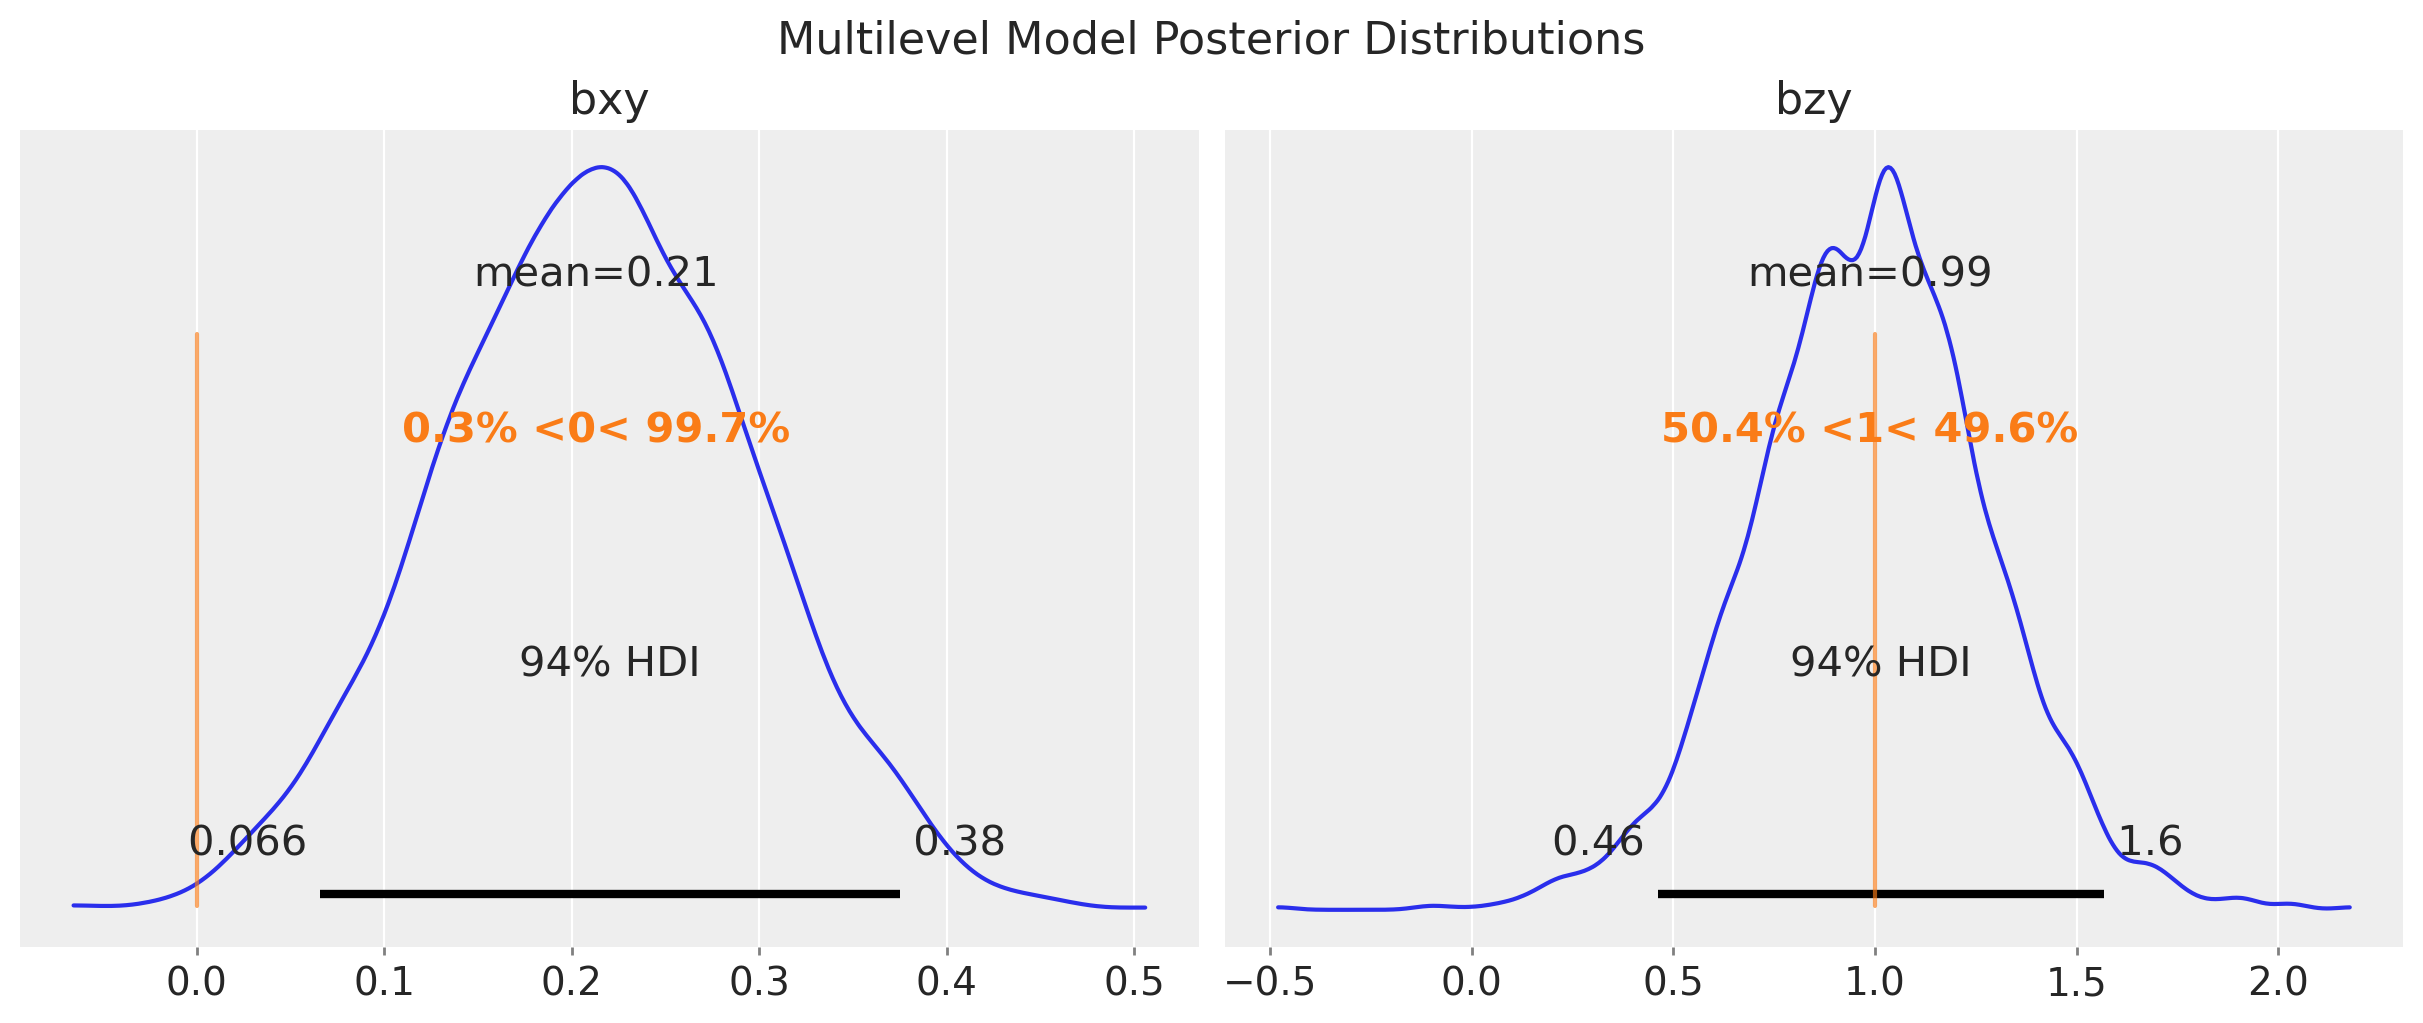

In [19]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_multilevel,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Multilevel Model Posterior Distributions", fontsize=16);

In this case, the multilevel model is not able to estimate the true value of $b_{xy}$. The reason is that it is not really factoring out the group-level confounding through the mean. Still, for this model, $b_{zy}$ is correctly estimated with narrower uncertainty as compared to the fixed effects model:

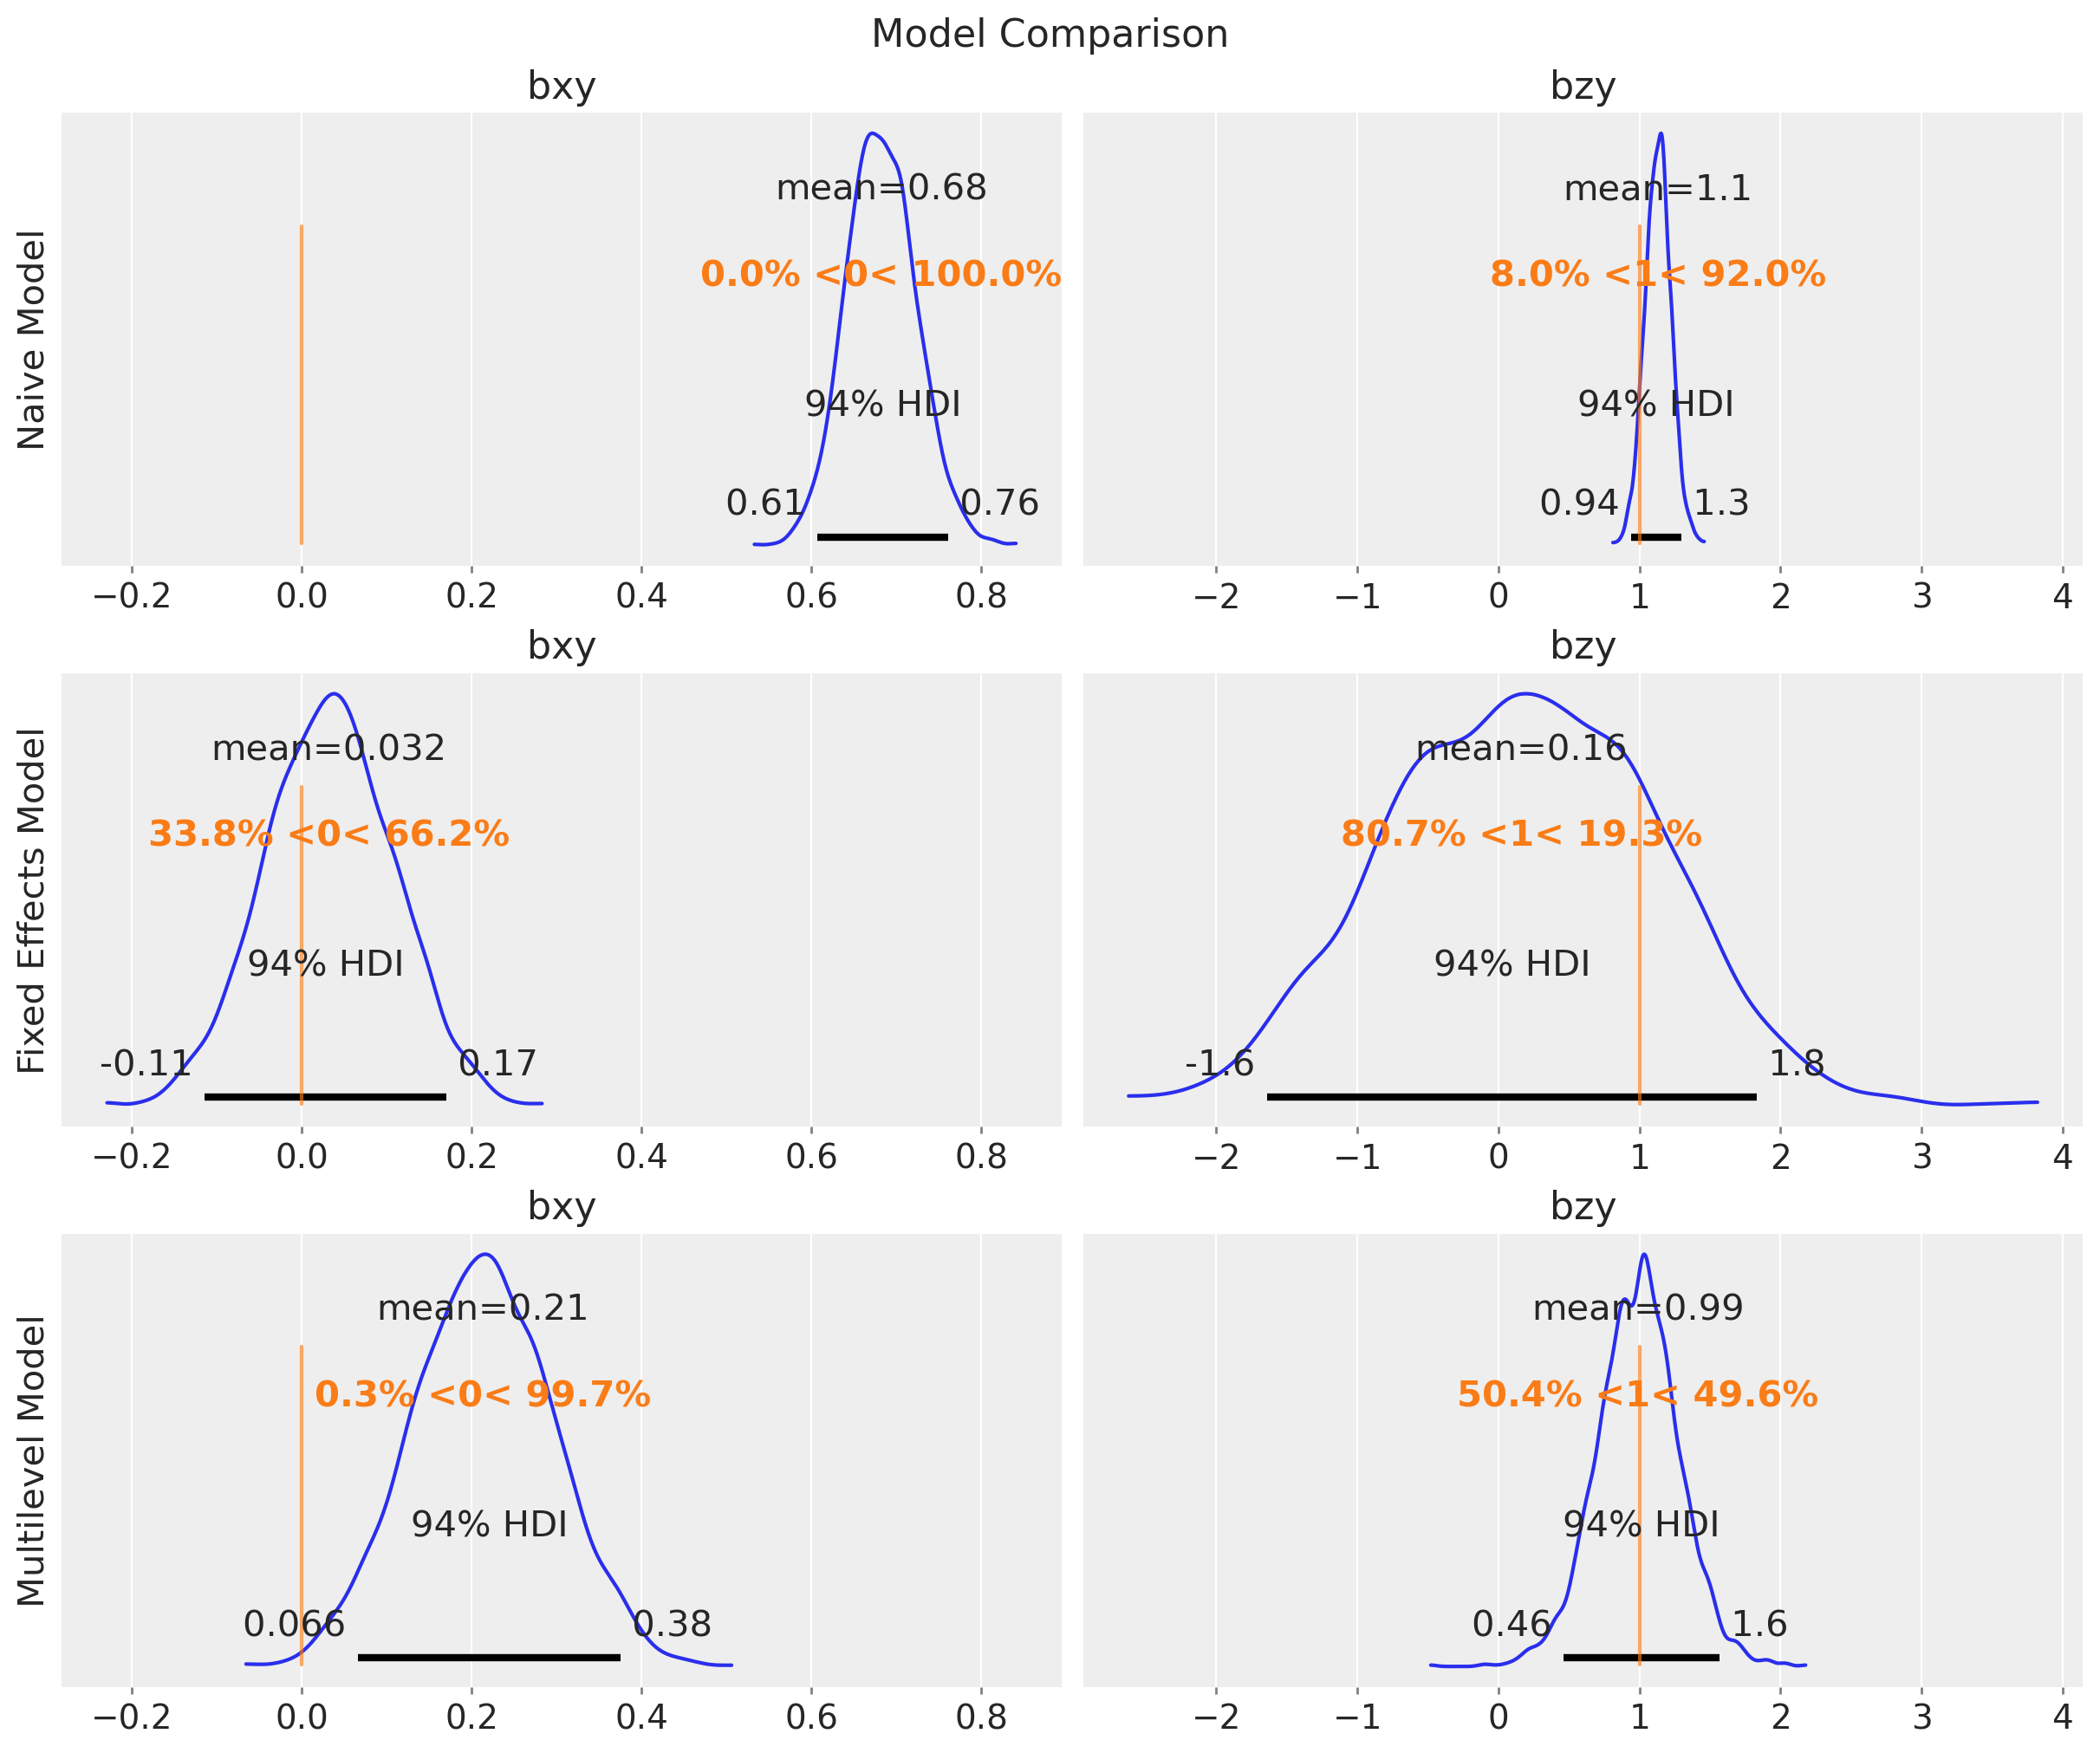

In [20]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 10),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

az.plot_posterior(
    idata_multilevel,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[2],
)

ax[0, 0].set(ylabel="Naive Model")
ax[1, 0].set(ylabel="Fixed Effects Model")
ax[2, 0].set(ylabel="Multilevel Model")

fig.suptitle("Model Comparison", fontsize=16);

## Mundlak Model

This is a cool trick! The idea is to explicitly add the group-level mean of $x$ as a predictor as a proxy for the unmeasured group-level confounder. We keep the (non-centered) multilevel model structure.

In [21]:
xbar_obs = data_df.groupby("group")["x"].mean().to_numpy()

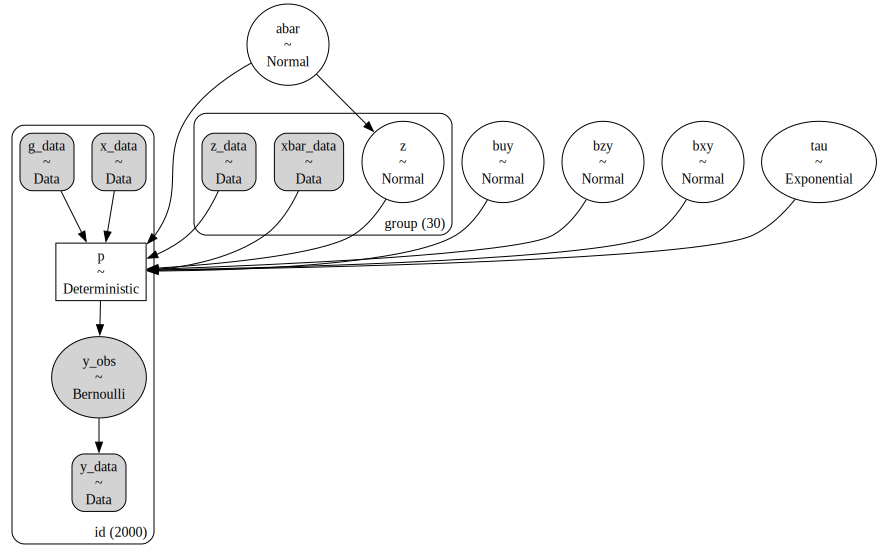

In [22]:
with pm.Model(coords=coords) as mundlak_model:
    x_data = pm.Data("x_data", x_obs, dims="id")
    y_data = pm.Data("y_data", y_obs, dims="id")
    g_data = pm.Data("g_data", g, dims="id")
    z_data = pm.Data("z_data", z_obs, dims="group")
    xbar_data = pm.Data("xbar_data", xbar_obs, dims="group")

    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)
    buy = pm.Normal("buy", mu=0, sigma=1)
    abar = pm.Normal("abar", mu=0, sigma=1)
    tau = pm.Exponential("tau", lam=1)
    z = pm.Normal("z", mu=abar, sigma=1, dims="group")

    a = abar + z * tau

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            a[g_data] + bxy * x_data + bzy * z_data[g_data] + buy * xbar_data[g_data]
        ),
        dims="id",
    )
    pm.Bernoulli("y_obs", p, dims="id", observed=y_data)

pm.model_to_graphviz(mundlak_model)

In [23]:
with mundlak_model:
    idata_mundlak = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        cores=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

    pm.compute_log_likelihood(idata_mundlak)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,1,0.43,15
,2000,0,0.46,7
,2000,0,0.45,15
,2000,0,0.43,7


Output()

This model is able to estimate the true value of $b_{xy}$ and $b_{zy}$ with narrower uncertainty for $b_{zy}$ as compared to the fixed effects model.

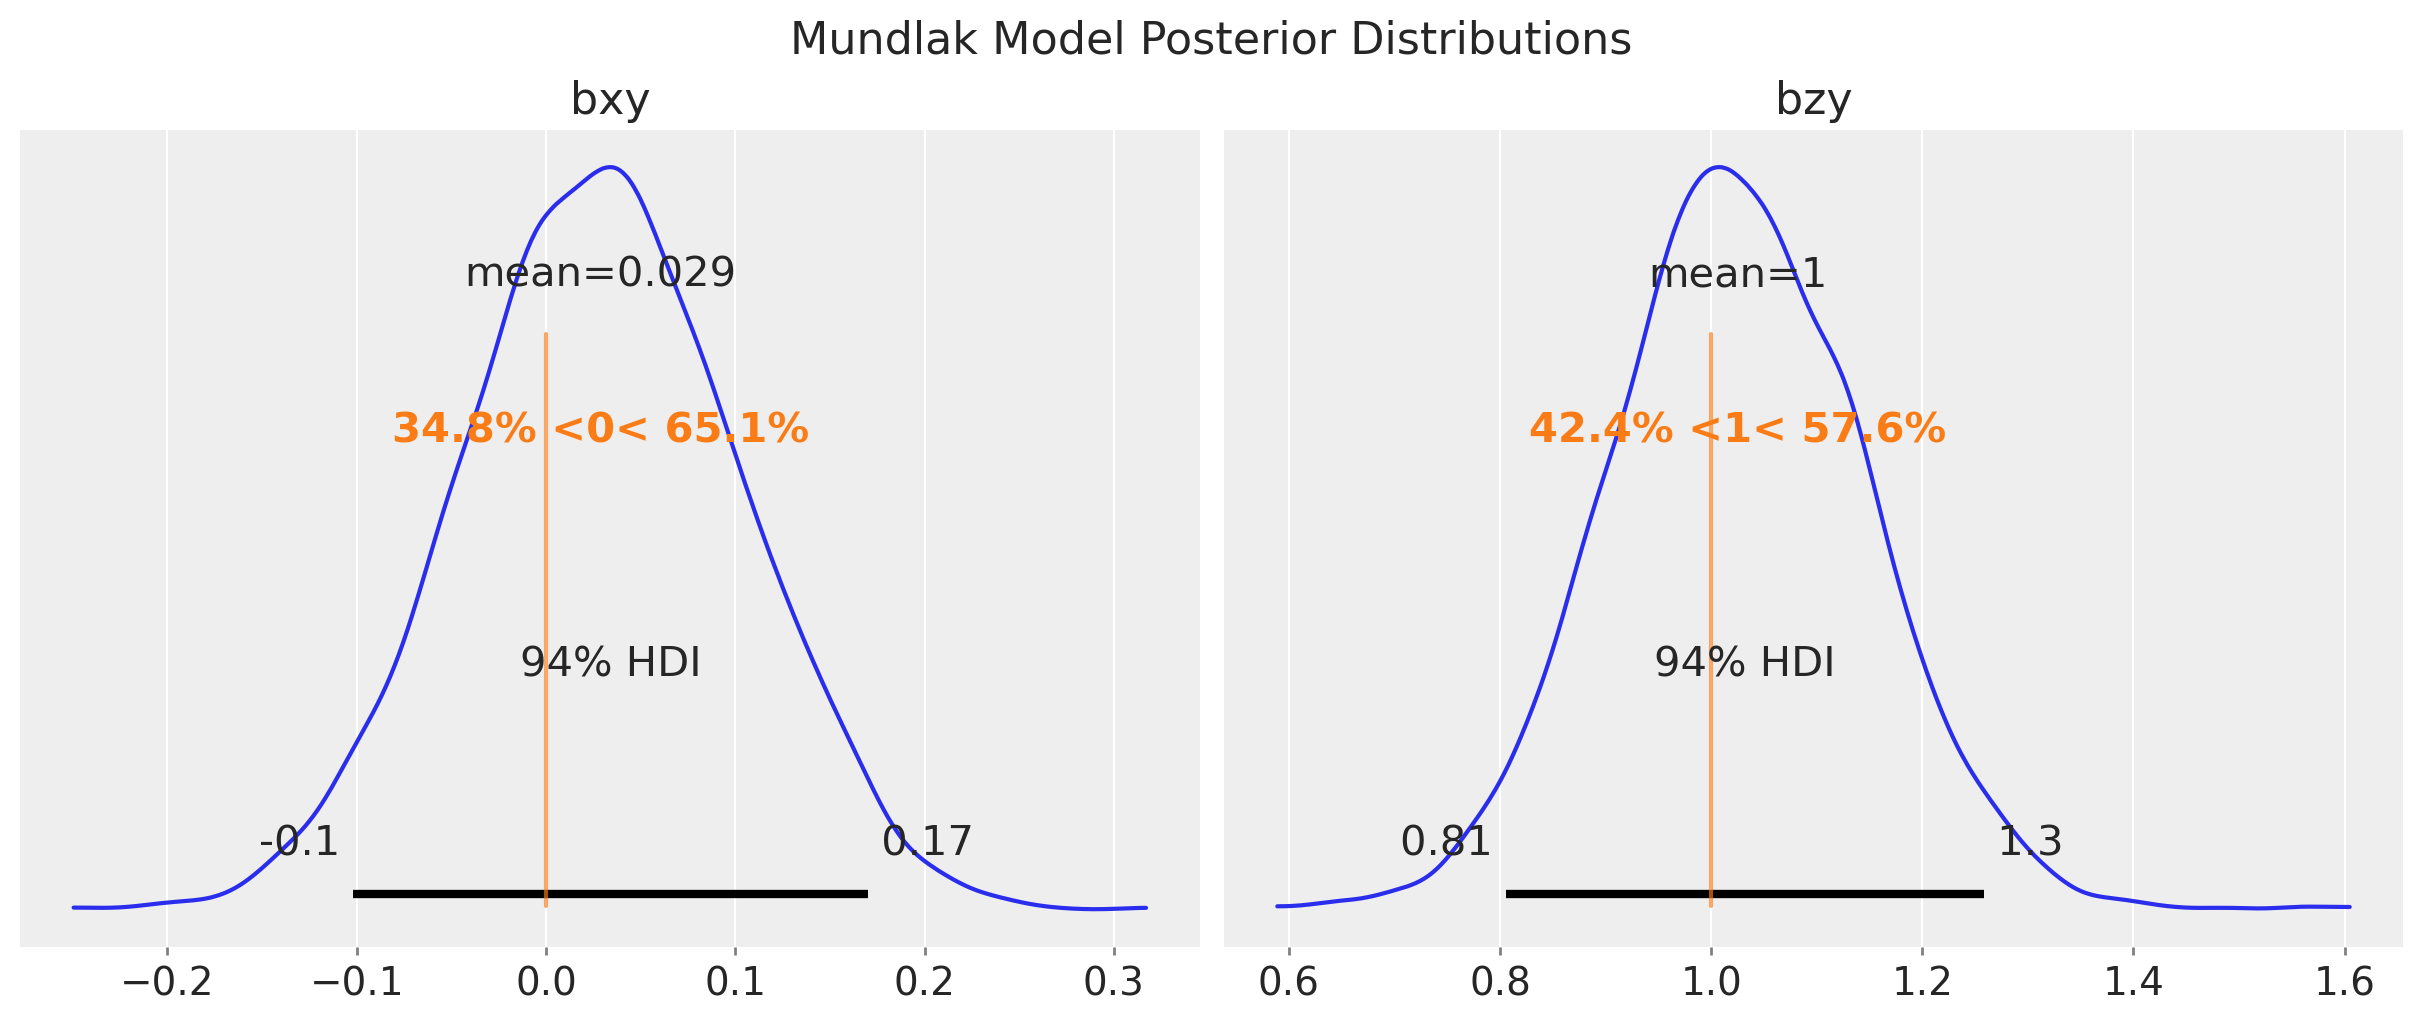

In [24]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_mundlak,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Mundlak Model Posterior Distributions", fontsize=16);

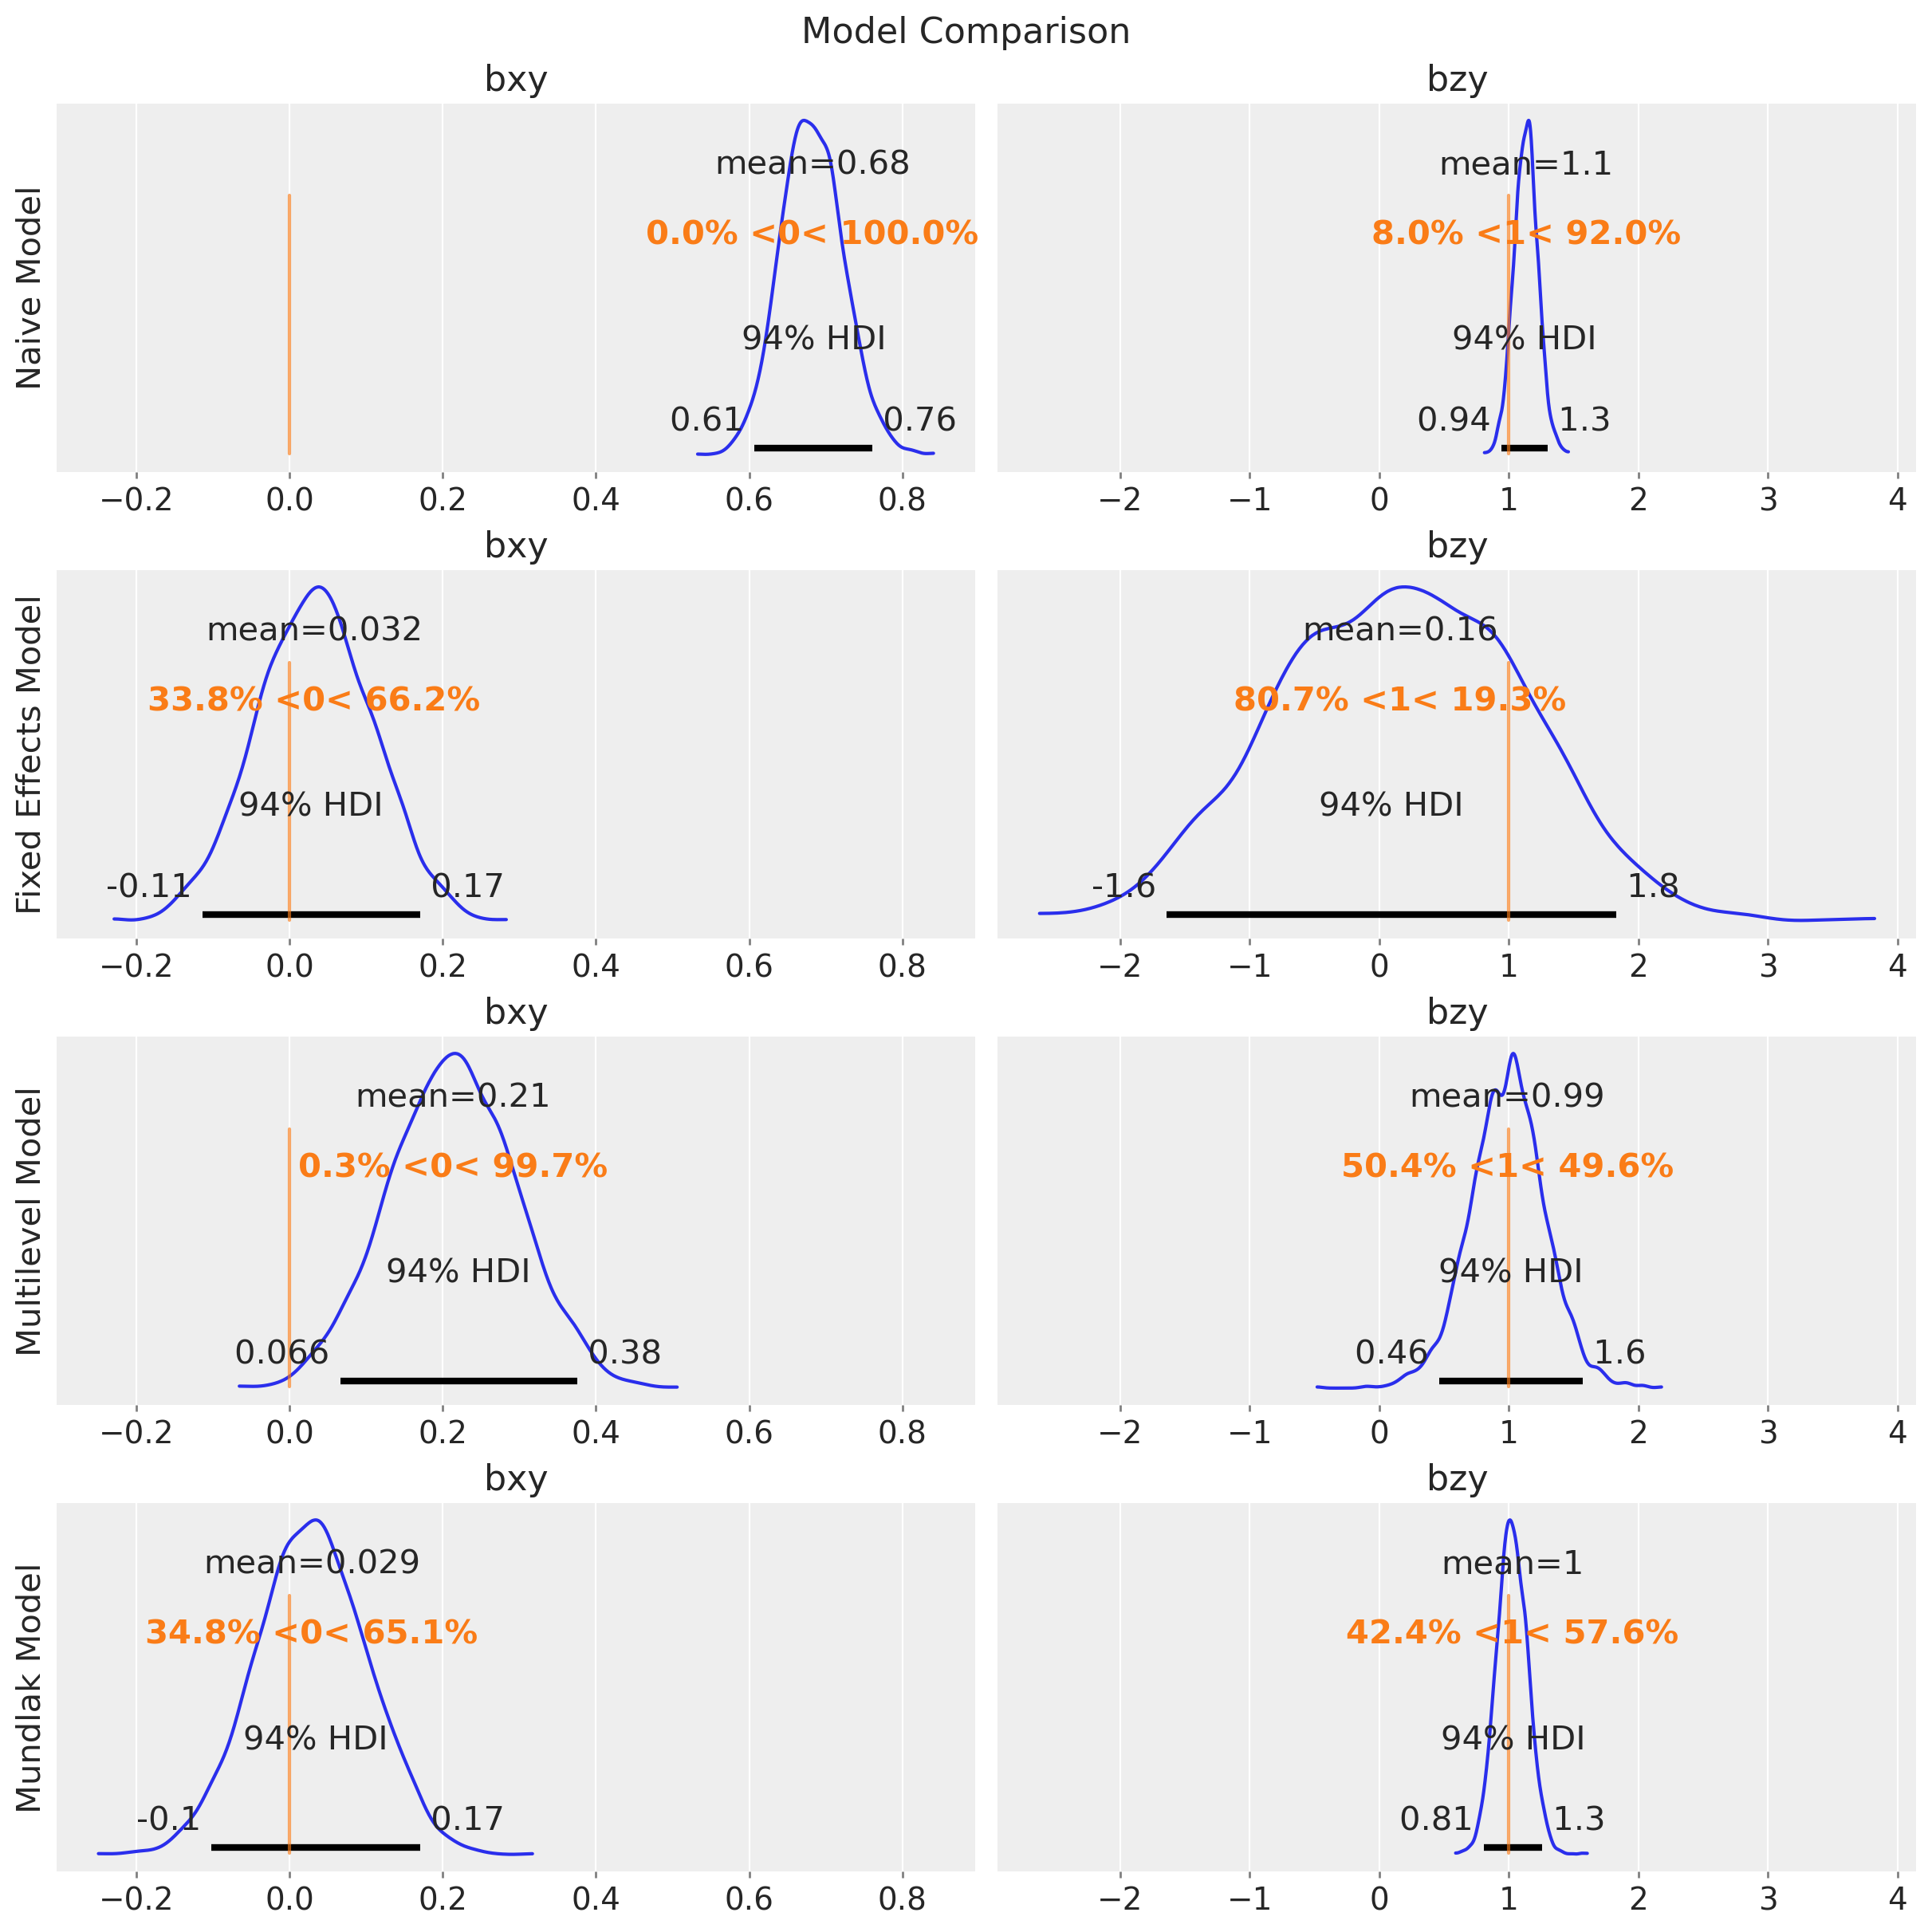

In [25]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(12, 12),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

az.plot_posterior(
    idata_multilevel,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[2],
)

az.plot_posterior(
    idata_mundlak,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[3],
)

ax[0, 0].set(ylabel="Naive Model")
ax[1, 0].set(ylabel="Fixed Effects Model")
ax[2, 0].set(ylabel="Multilevel Model")
ax[3, 0].set(ylabel="Mundlak Model")
fig.suptitle("Model Comparison", fontsize=16);

## Mundlak Latent Model

Finally, we make the trick above more *Bayesian* by adding a latent variable and an additional likelihood for $x$. This is very similar to the approach taken in the example notebook ["Causal Effect Estimation with Variational Inference and Latent Confounders"](https://juanitorduz.github.io/online_game_ate/).


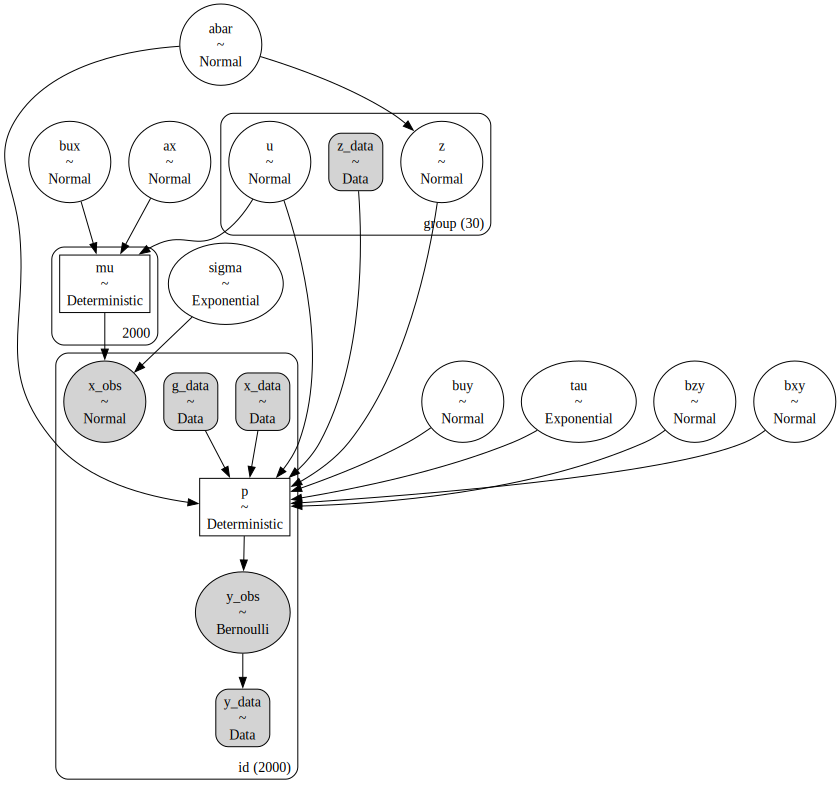

In [ ]:
with pm.Model(coords=coords) as mundlak_latent_model:
    x_data = pm.Data("x_data", x_obs, dims="id")
    y_data = pm.Data("y_data", y_obs, dims="id")
    g_data = pm.Data("g_data", g, dims="id")
    z_data = pm.Data("z_data", z_obs, dims="group")

    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)
    buy = pm.Normal("buy", mu=0, sigma=1)
    bux = pm.Normal("bux", mu=0, sigma=1)
    abar = pm.Normal("abar", mu=0, sigma=1)
    tau = pm.Exponential("tau", lam=1)
    z = pm.Normal("z", mu=abar, sigma=1, dims="group")
    ug = pm.Normal("u", mu=0, sigma=1, dims="group")
    ax = pm.Normal("ax", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    mu = pm.Deterministic("mu", ax + bux * ug[g_data])

    pm.Normal("x_obs", mu=mu, sigma=sigma, dims="id", observed=x_obs)

    a = abar + z * tau

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            a[g_data] + bxy * x_data + bzy * z_data[g_data] + buy * ug[g_data]
        ),
        dims="id",
    )
    pm.Bernoulli("y_obs", p, dims="id", observed=y_data)


pm.model_to_graphviz(mundlak_latent_model)

In [27]:
with mundlak_latent_model:
    idata_mundlak_latent = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        cores=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

    pm.compute_log_likelihood(idata_mundlak_latent, var_names=["y_obs"])

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.31,15
,2000,0,0.28,15
,2000,0,0.28,47
,2000,0,0.27,15


Output()

We get similar results as the Mundlak model.

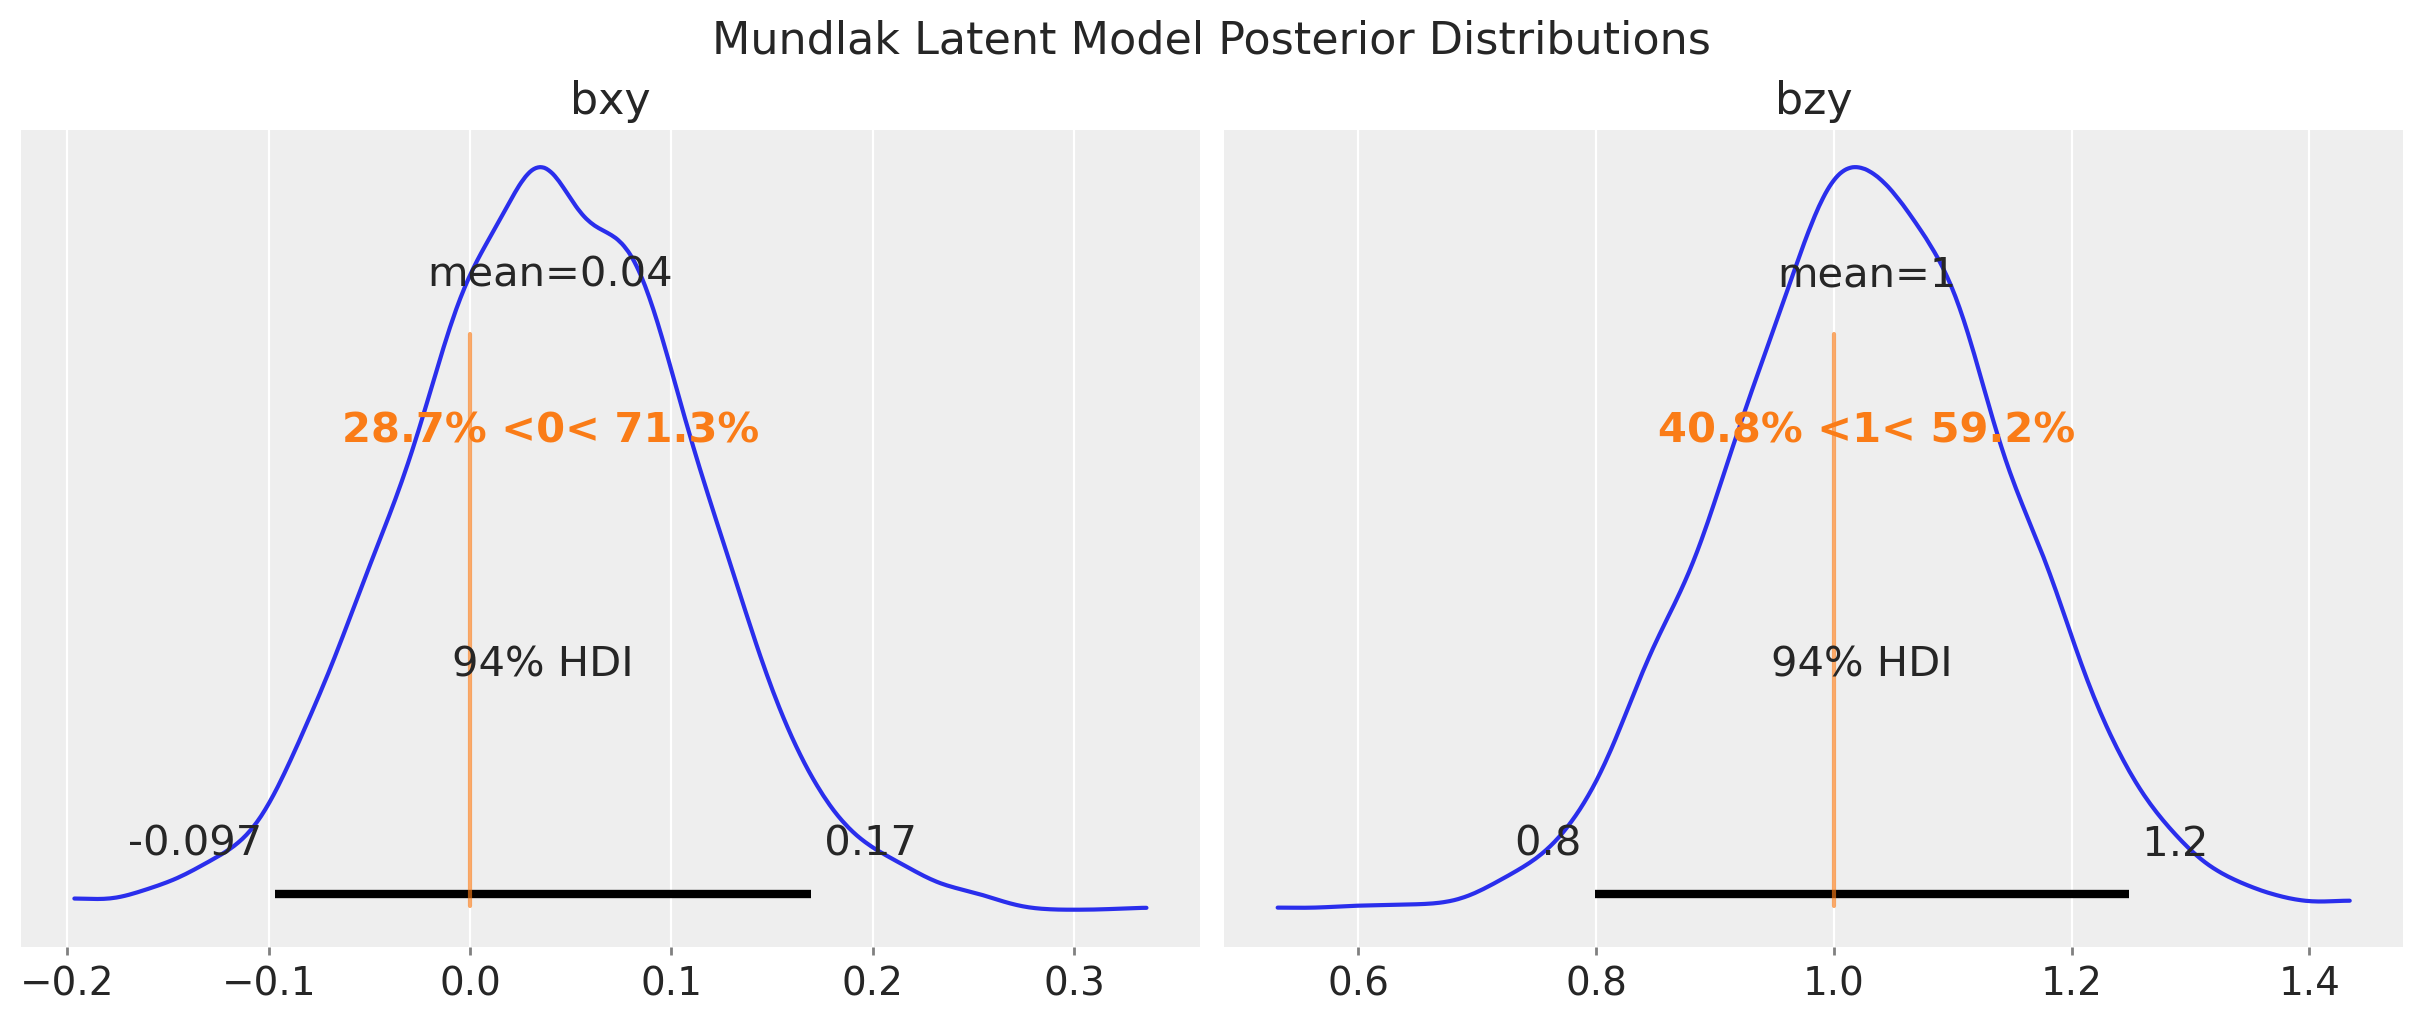

In [28]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_mundlak_latent,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Mundlak Latent Model Posterior Distributions", fontsize=16);

Let's compare all the models:

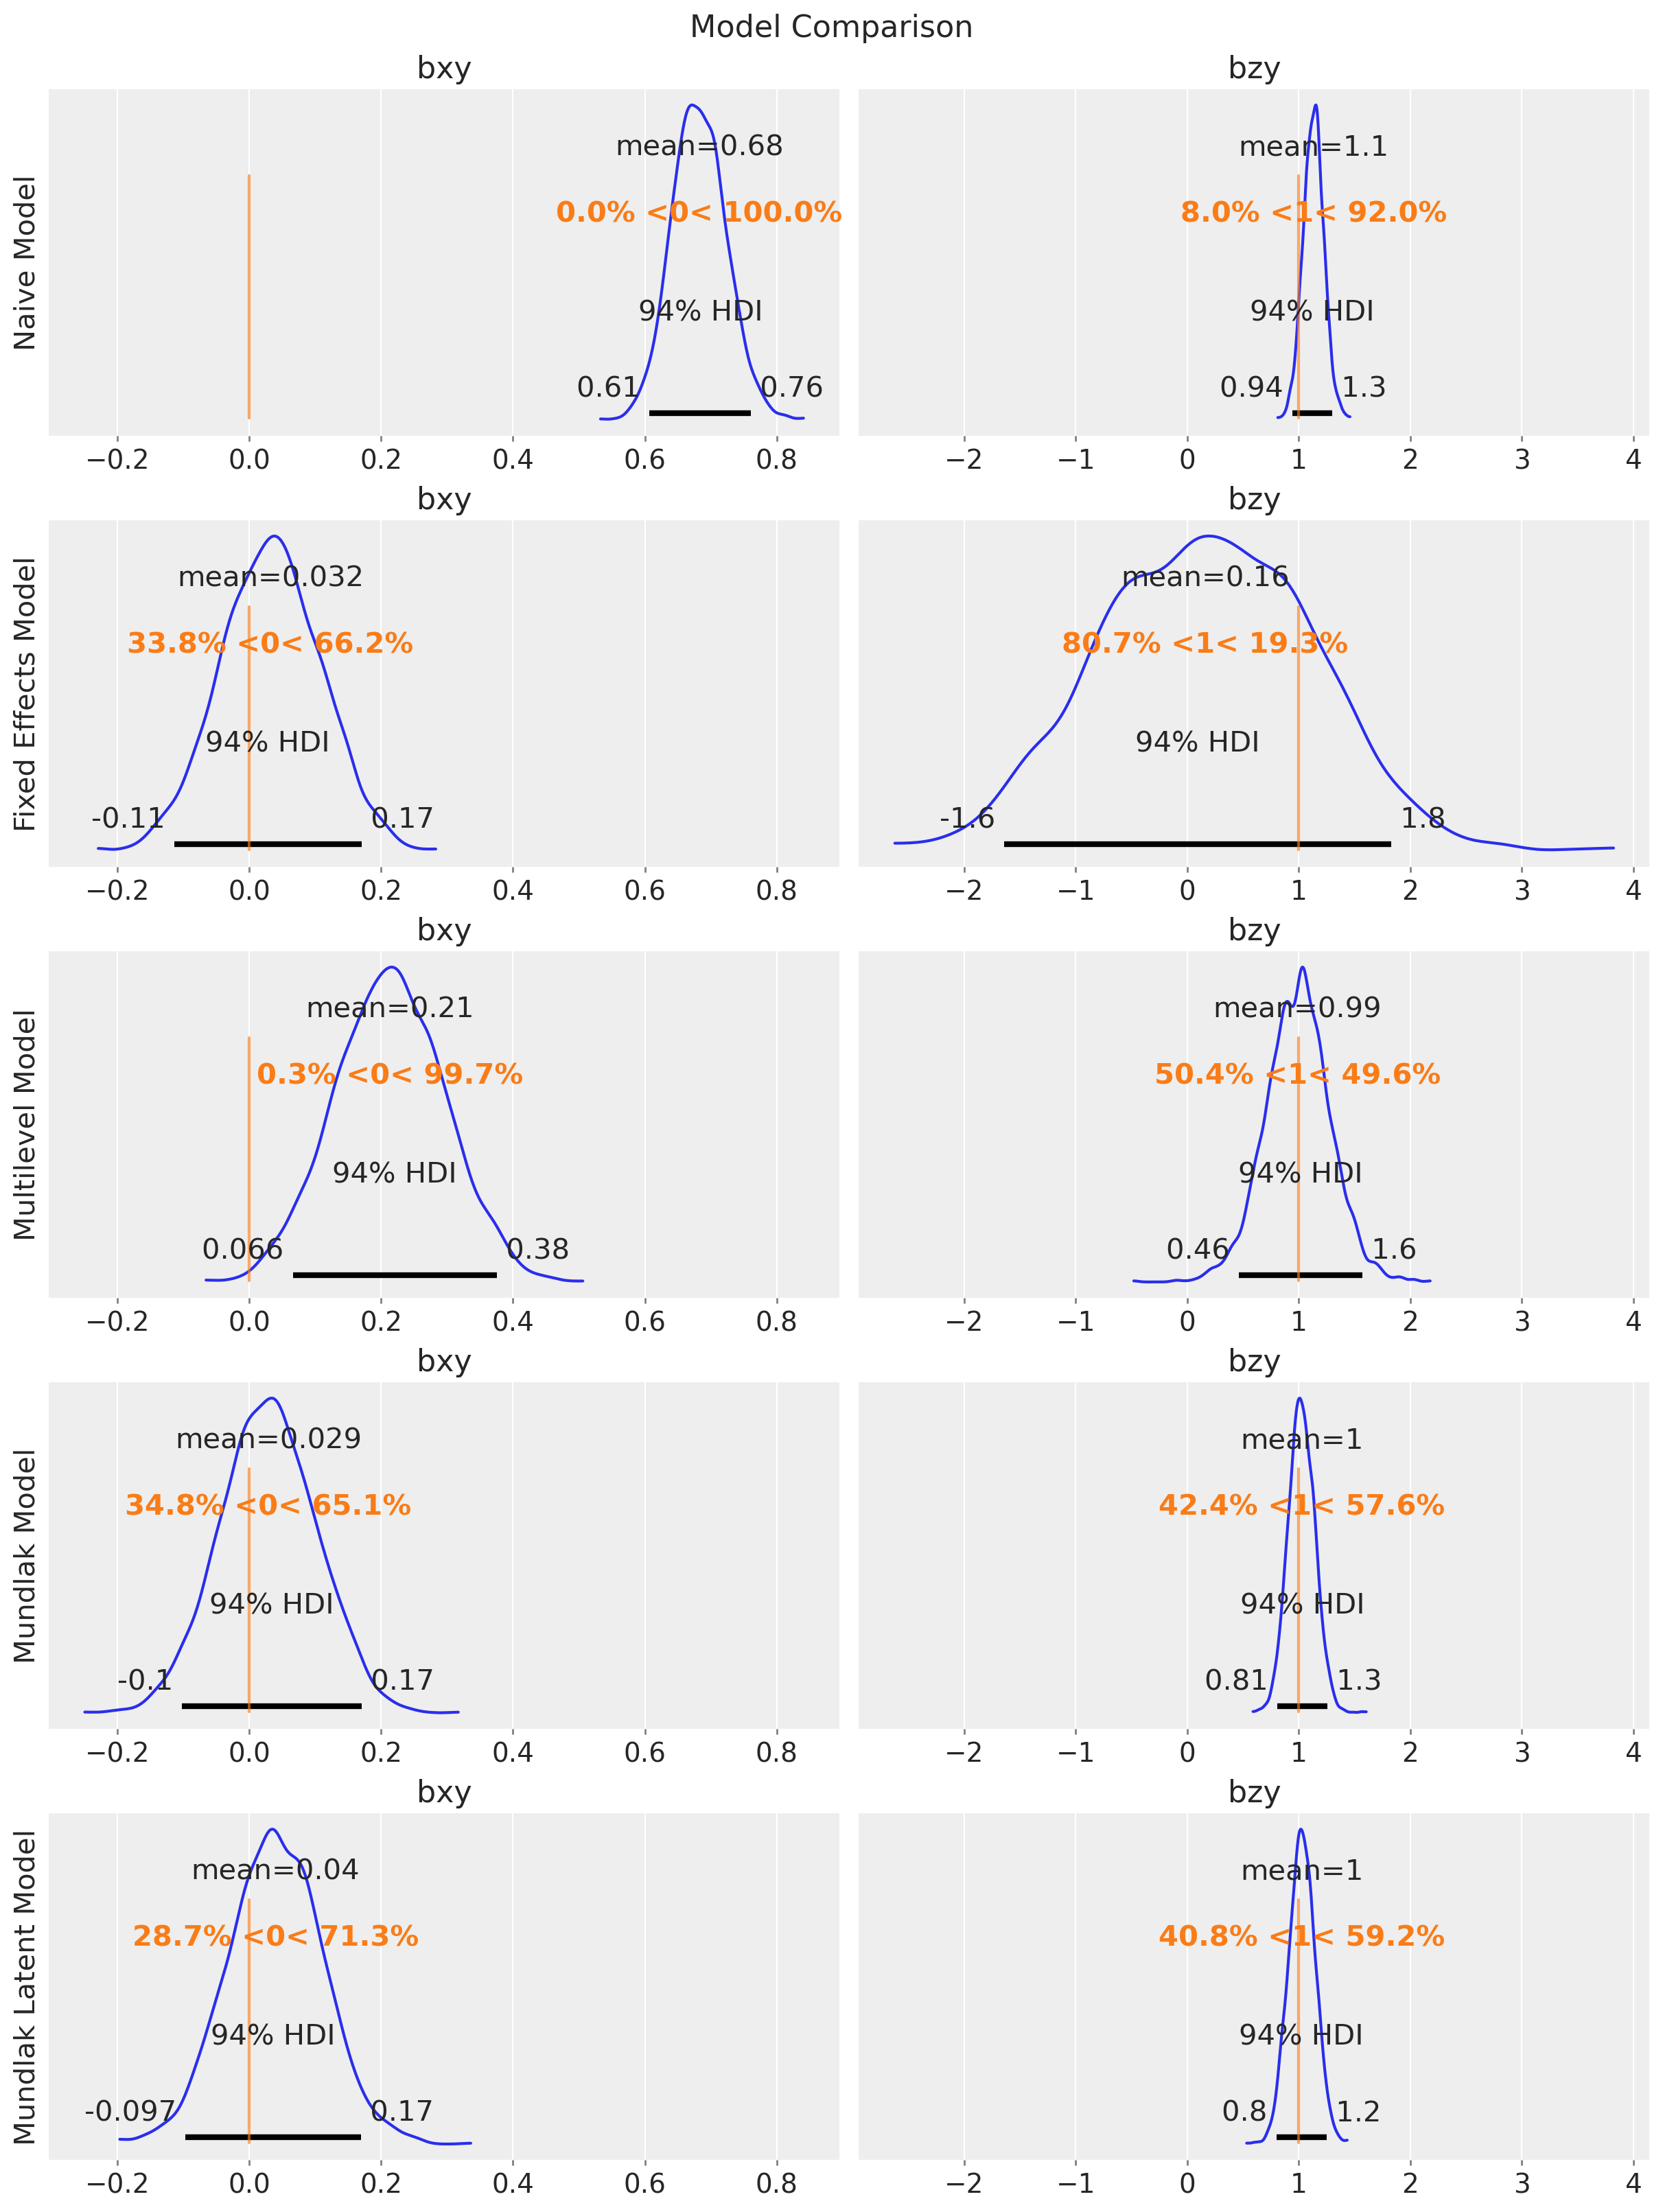

In [29]:
fig, ax = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=(12, 16),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

az.plot_posterior(
    idata_multilevel,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[2],
)

az.plot_posterior(
    idata_mundlak,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[3],
)

az.plot_posterior(
    idata_mundlak_latent,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[4],
)

ax[0, 0].set(ylabel="Naive Model")
ax[1, 0].set(ylabel="Fixed Effects Model")
ax[2, 0].set(ylabel="Multilevel Model")
ax[3, 0].set(ylabel="Mundlak Model")
ax[4, 0].set(ylabel="Mundlak Latent Model")

fig.suptitle("Model Comparison", fontsize=16);

## Model Comparison

We can also have a more compact visualization of the parameter estimates:

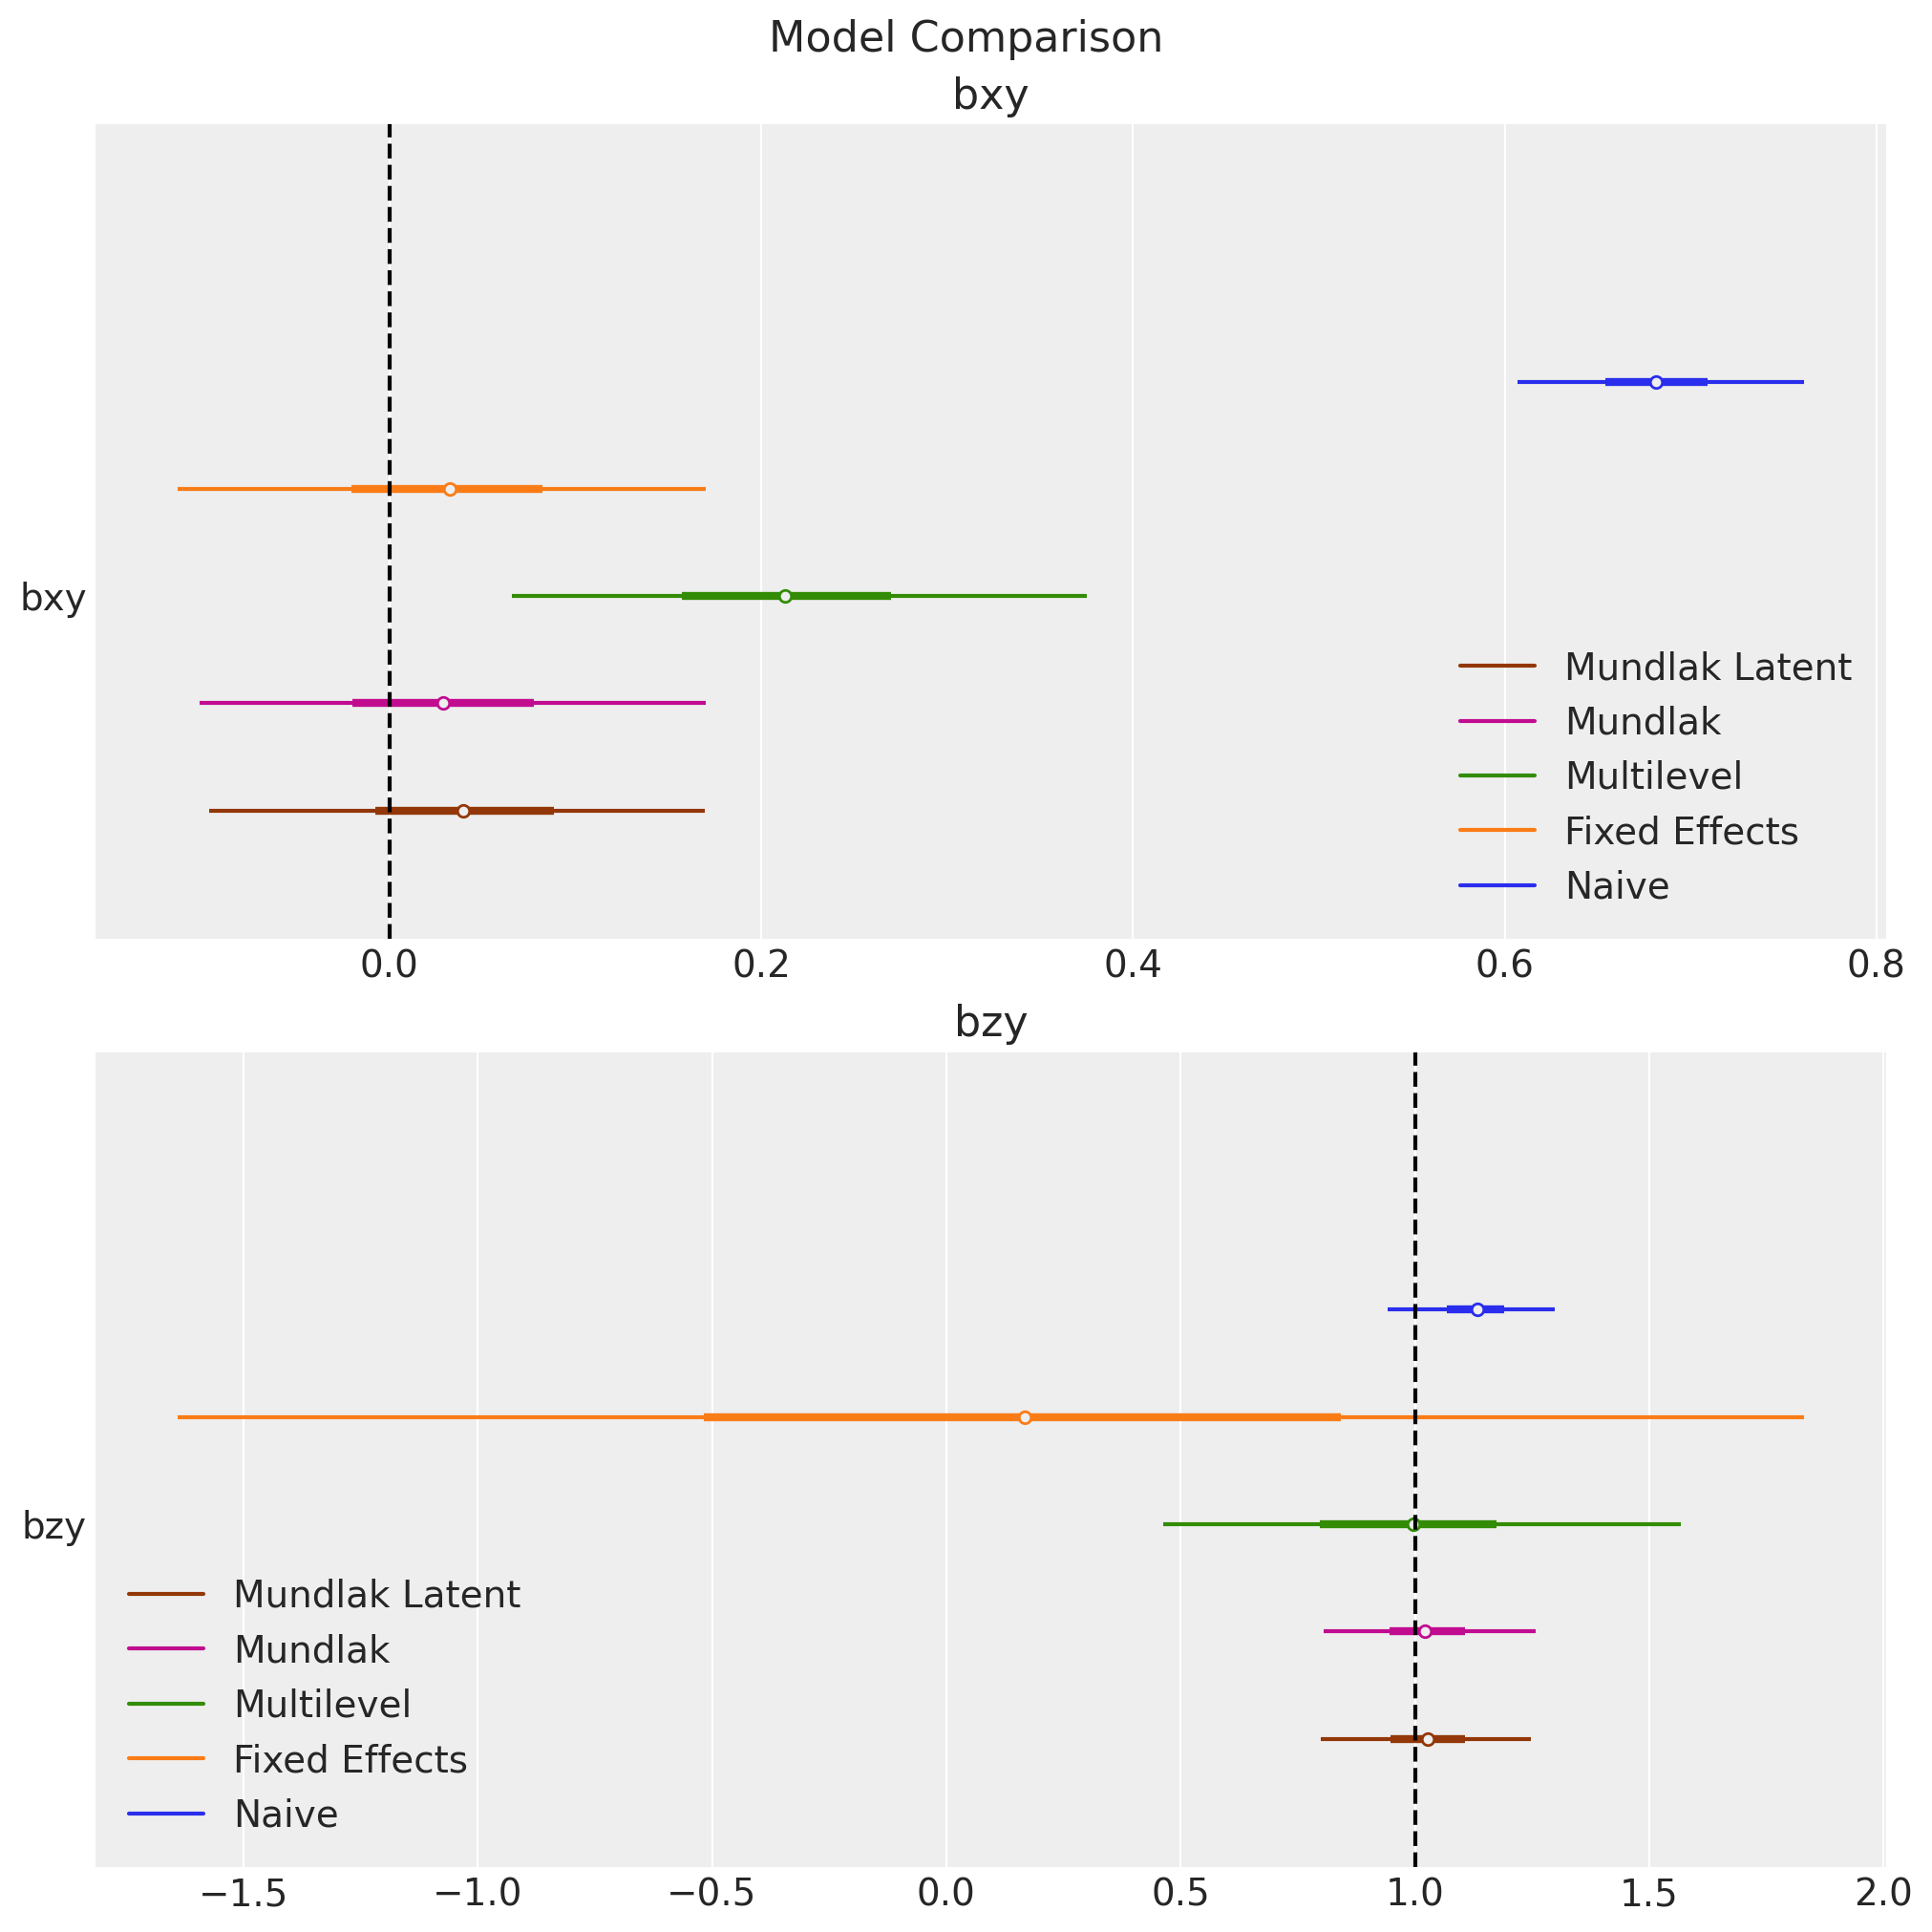

In [30]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=1)

az.plot_forest(
    data=[
        idata_naive,
        idata_fixed_effects,
        idata_multilevel,
        idata_mundlak,
        idata_mundlak_latent,
    ],
    model_names=["Naive", "Fixed Effects", "Multilevel", "Mundlak", "Mundlak Latent"],
    var_names=["bxy"],
    combined=True,
    ax=ax[0],
)

ax[0].axvline(x=true_params["bxy"], color="k", linestyle="--")

ax[0].get_legend().set_loc("lower right")
ax[0].set_title("bxy", fontsize=16)

az.plot_forest(
    data=[
        idata_naive,
        idata_fixed_effects,
        idata_multilevel,
        idata_mundlak,
        idata_mundlak_latent,
    ],
    model_names=[
        "Naive",
        "Fixed Effects",
        "Multilevel",
        "Mundlak",
        "Mundlak Latent",
    ],
    var_names=["bzy"],
    combined=True,
    ax=ax[1],
)

ax[1].axvline(x=true_params["bzy"], color="k", linestyle="--")

ax[1].get_legend().set_loc("lower left")
ax[1].set_title("bzy", fontsize=16)

fig.suptitle("Model Comparison", fontsize=16);

Finally, we can compare the models using the LOO information criterion:

/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


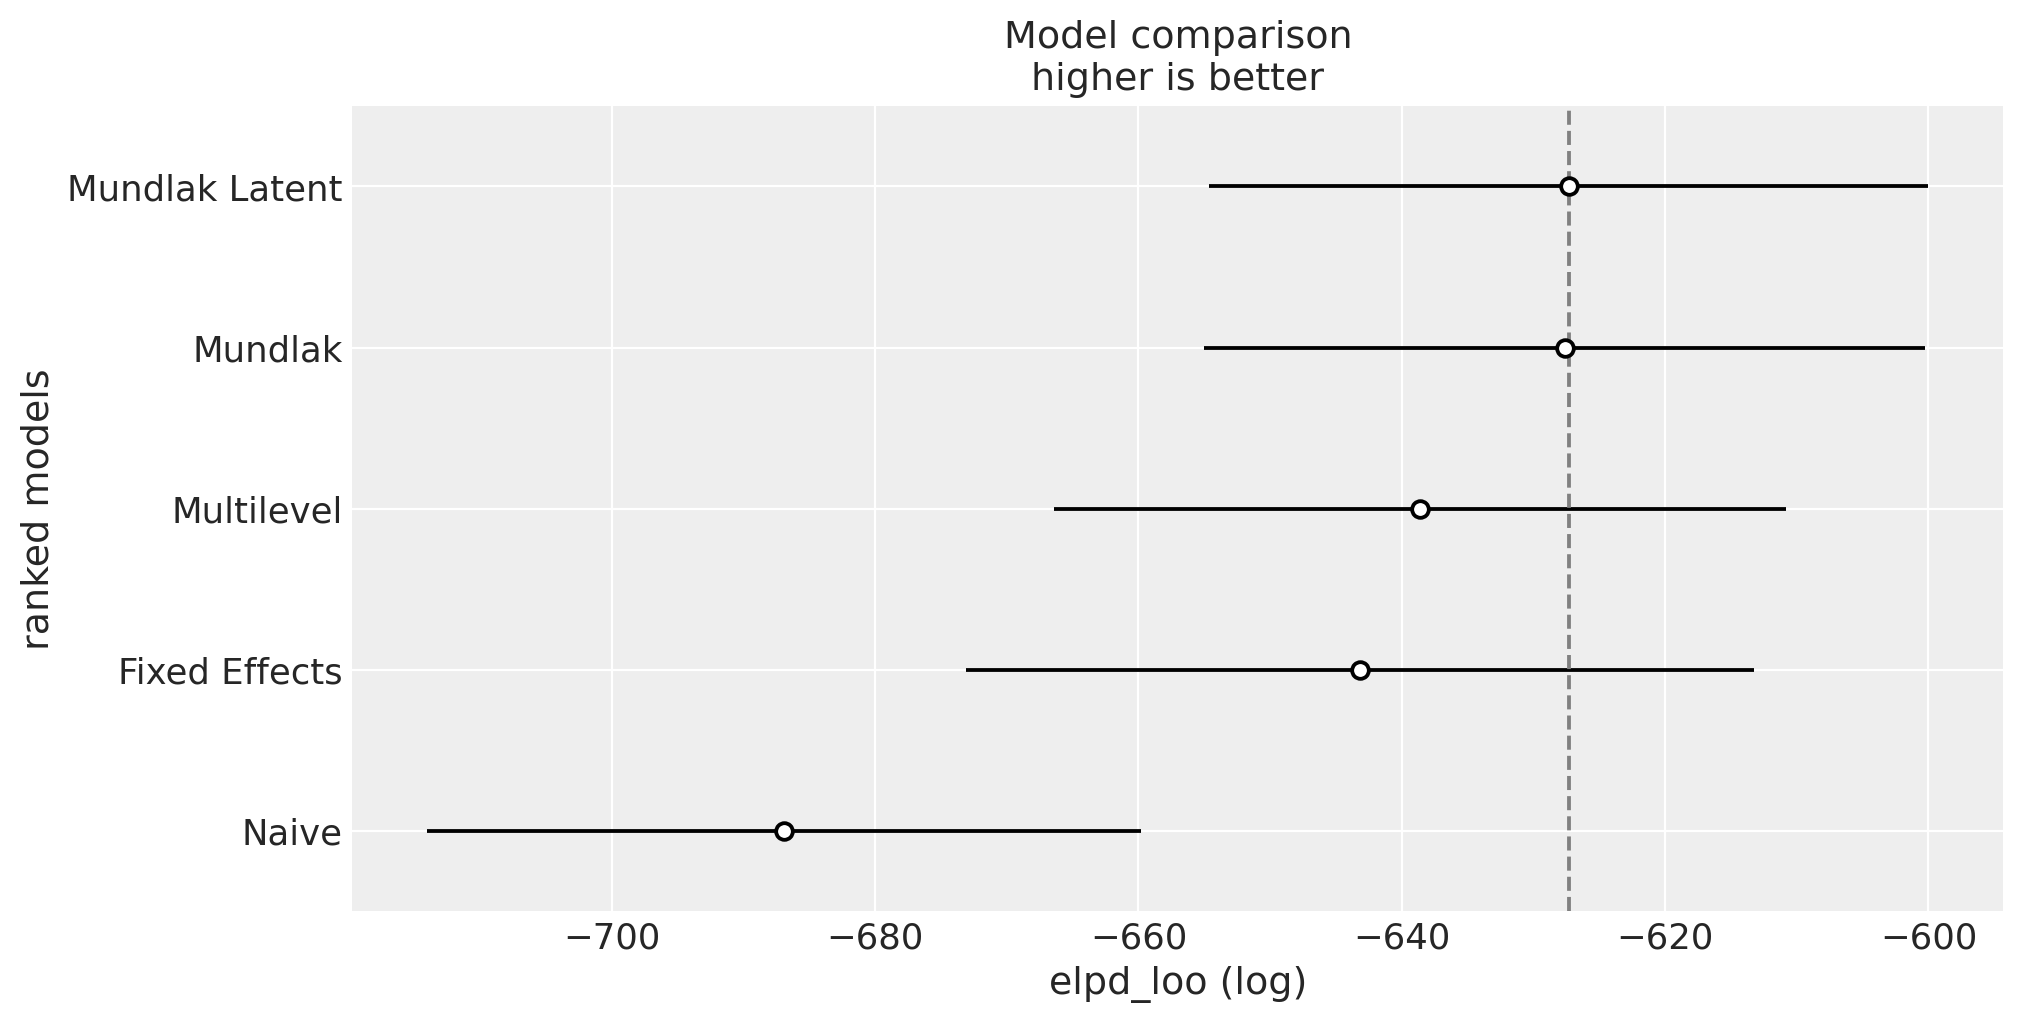

In [31]:
comp_df = az.compare(
    {
        "Naive": idata_naive,
        "Fixed Effects": idata_fixed_effects,
        "Multilevel": idata_multilevel,
        "Mundlak": idata_mundlak,
        "Mundlak Latent": idata_mundlak_latent,
    },
    ic="loo",
)

az.plot_compare(comp_df, figsize=(10, 5));

We see that the Mundlak latent model is the best model according to the LOO information criterion (but is very close to the Mundlak model).

This was a great learning experience! Thank you Richard McElreath!